In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')
sys.path.append('/Users/naveenr/Documents/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
import geopandas as gpd
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize

In [4]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data
from patient.plotting import *

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [7]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [8]:
style_size = 'paper'

In [9]:
methods = ['random','greedy','lp','group_based','gradient_descent_fast']
method_labels = ["Random","Greedy","Pairwise","Group-Based","Gradient Descent"]

# WINE Plots

## Synthetic Experiments

### Performance Comparison

In [50]:
x_values = [2,3,4,5]
dataset = 'small'

provider_y_values = [[] for i in range(len(methods))]
provider_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_patients': 2, 'fairness_weight': 0}
for i in range(len(x_values)):
    baseline_params['num_providers'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(method_labels)):
        provider_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        provider_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

In [51]:
patient_y_values = [[] for i in range(len(methods))]
patient_y_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 2, 'fairness_weight': 0}
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i] 

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="optimal")
    for method in range(len(method_labels)):
        patient_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        patient_y_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

In [52]:
np.min(provider_y_values[1:]),np.min(patient_y_values[2])

(0.9655118367351369, 0.7224846069597077)

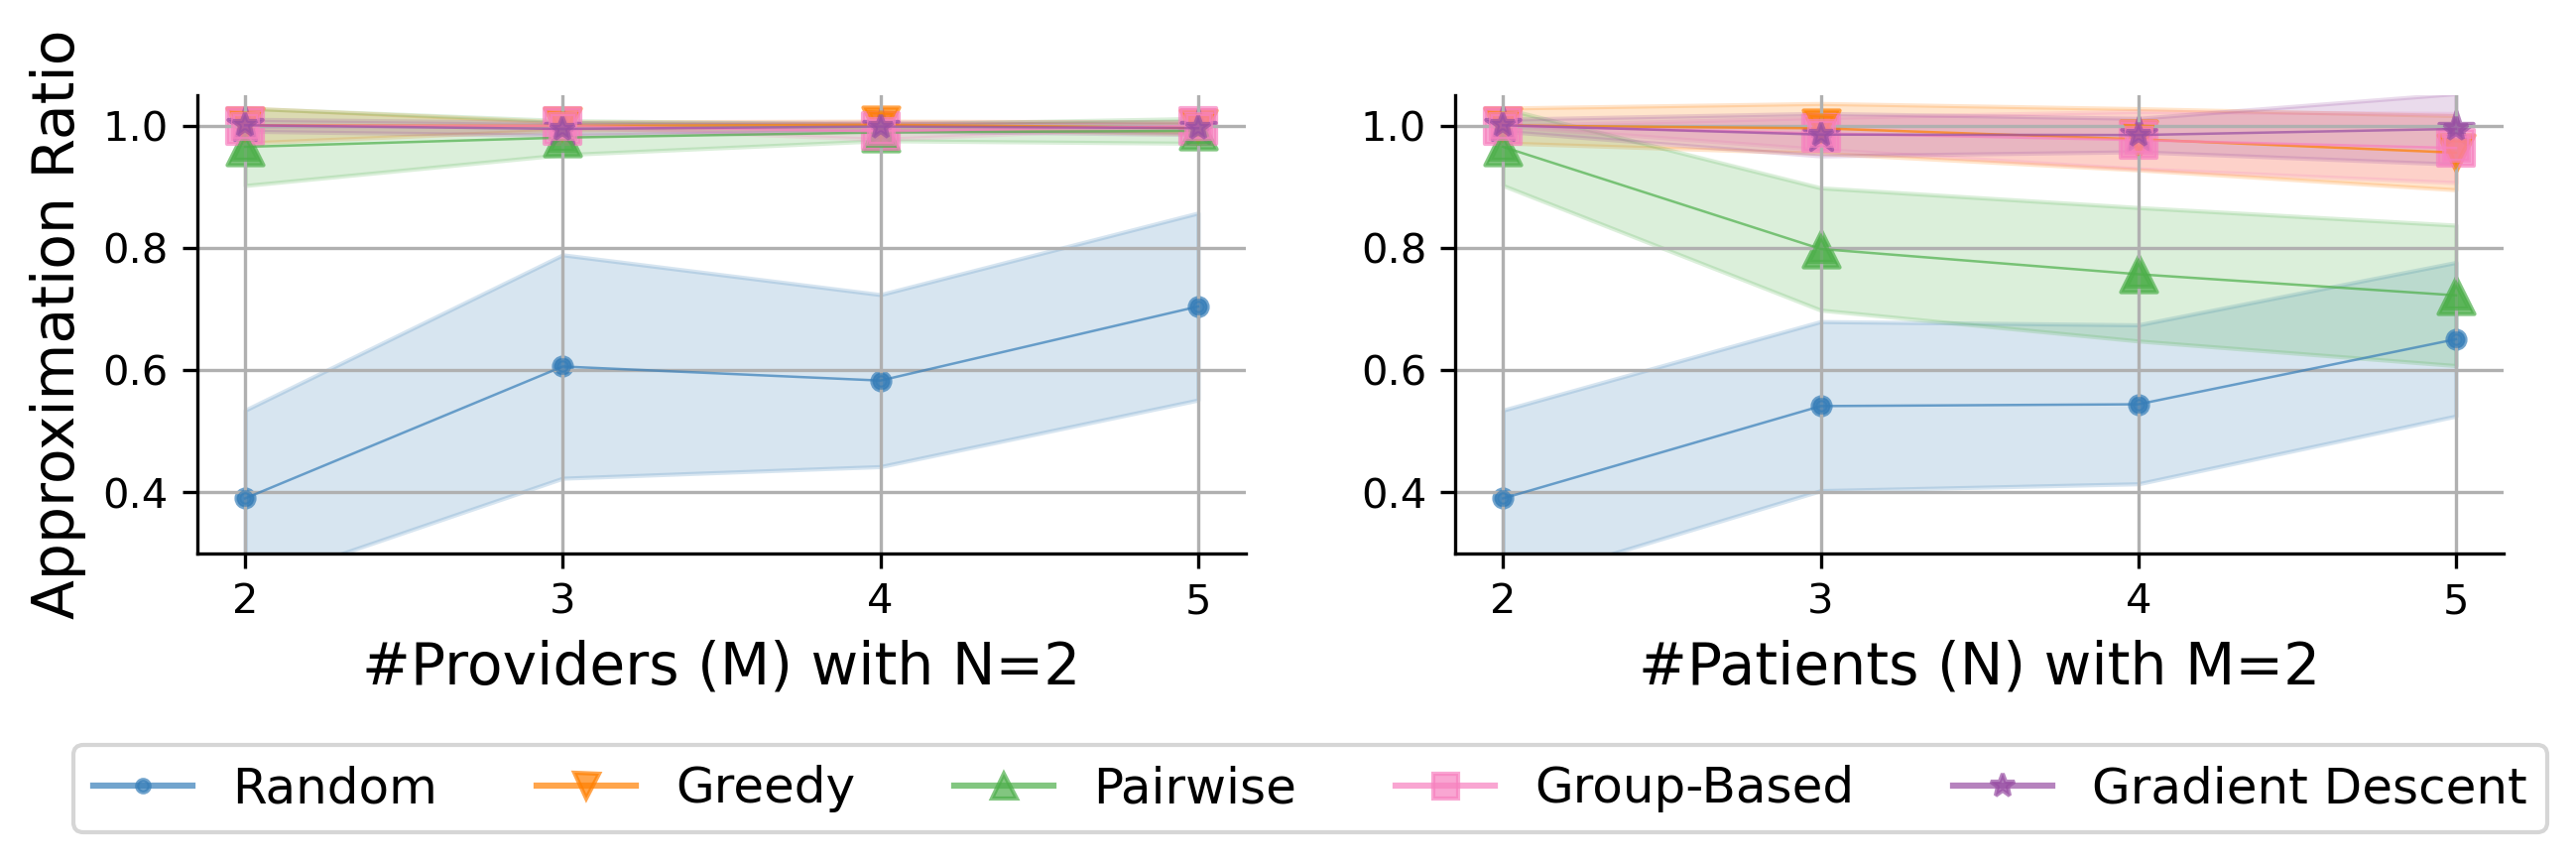

In [54]:
plot_dimensions = (1,2)
x_labels = [["#Providers (M) with N=2","#Patients (N) with M=2"]]
y_labels = [["Approximation Ratio",""]]
sup_y_label = ""
overall_format = {'figsize':(10,2),
    'style_size': style_size,
    'x_ticks': [[[[2,3,4,5],[2,3,4,5]],[[2,3,4,5],[2,3,4,5]]]],
    'y_ticks': [[[[0.4,0.6,0.8,1.0],[0.4,0.6,0.8,1.0]],[[0.4,0.6,0.8,1.0],[0.4,0.6,0.8,1.0]]]],
    'y_lim': [[[0.3,1.05],[0.3,1.05]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_y_label=sup_y_label)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,provider_y_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(provider_y_values))],provider_y_values,[],line_format)

plot_line(ax[0][1],[x_values for i in range(len(patient_y_values))],patient_y_values,patient_y_confidences,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(patient_y_confidences))],patient_y_values,[],line_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 5, 'bbox_to_anchor': (0.075,-0.4), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/small_patient_provider.pdf",dpi=300, bbox_inches='tight')

In [75]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [18]:
(y_value_matrix[-1][-1])[1]/(y_value_matrix[-1][-1])[2]

1.0

In [83]:
np.array(y_value_matrix)[0][-1][-1]/np.array(y_value_matrix)[0][-1][-2], np.array(y_value_matrix)[1][-1][1]/np.array(y_value_matrix)[1][-1][-2]

(0.9408499359593774, 0.9495212071915282)

In [19]:
(y_value_matrix[0][-1])[3]/(y_value_matrix[0][-1])[1],(y_value_matrix[-1][-1])[3]/(y_value_matrix[-1][-1])[1]

(1.0, 1.0)

In [20]:
(np.array(y_value_matrix)[:,:,3])/(np.array(y_value_matrix)[:,:,1])

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [21]:
(np.array(y_value_matrix)[:,:,3])/np.max(y_value_matrix,axis=2)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [22]:
np.array(y_value_matrix)[:,:,2]/np.max(y_value_matrix,axis=2)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

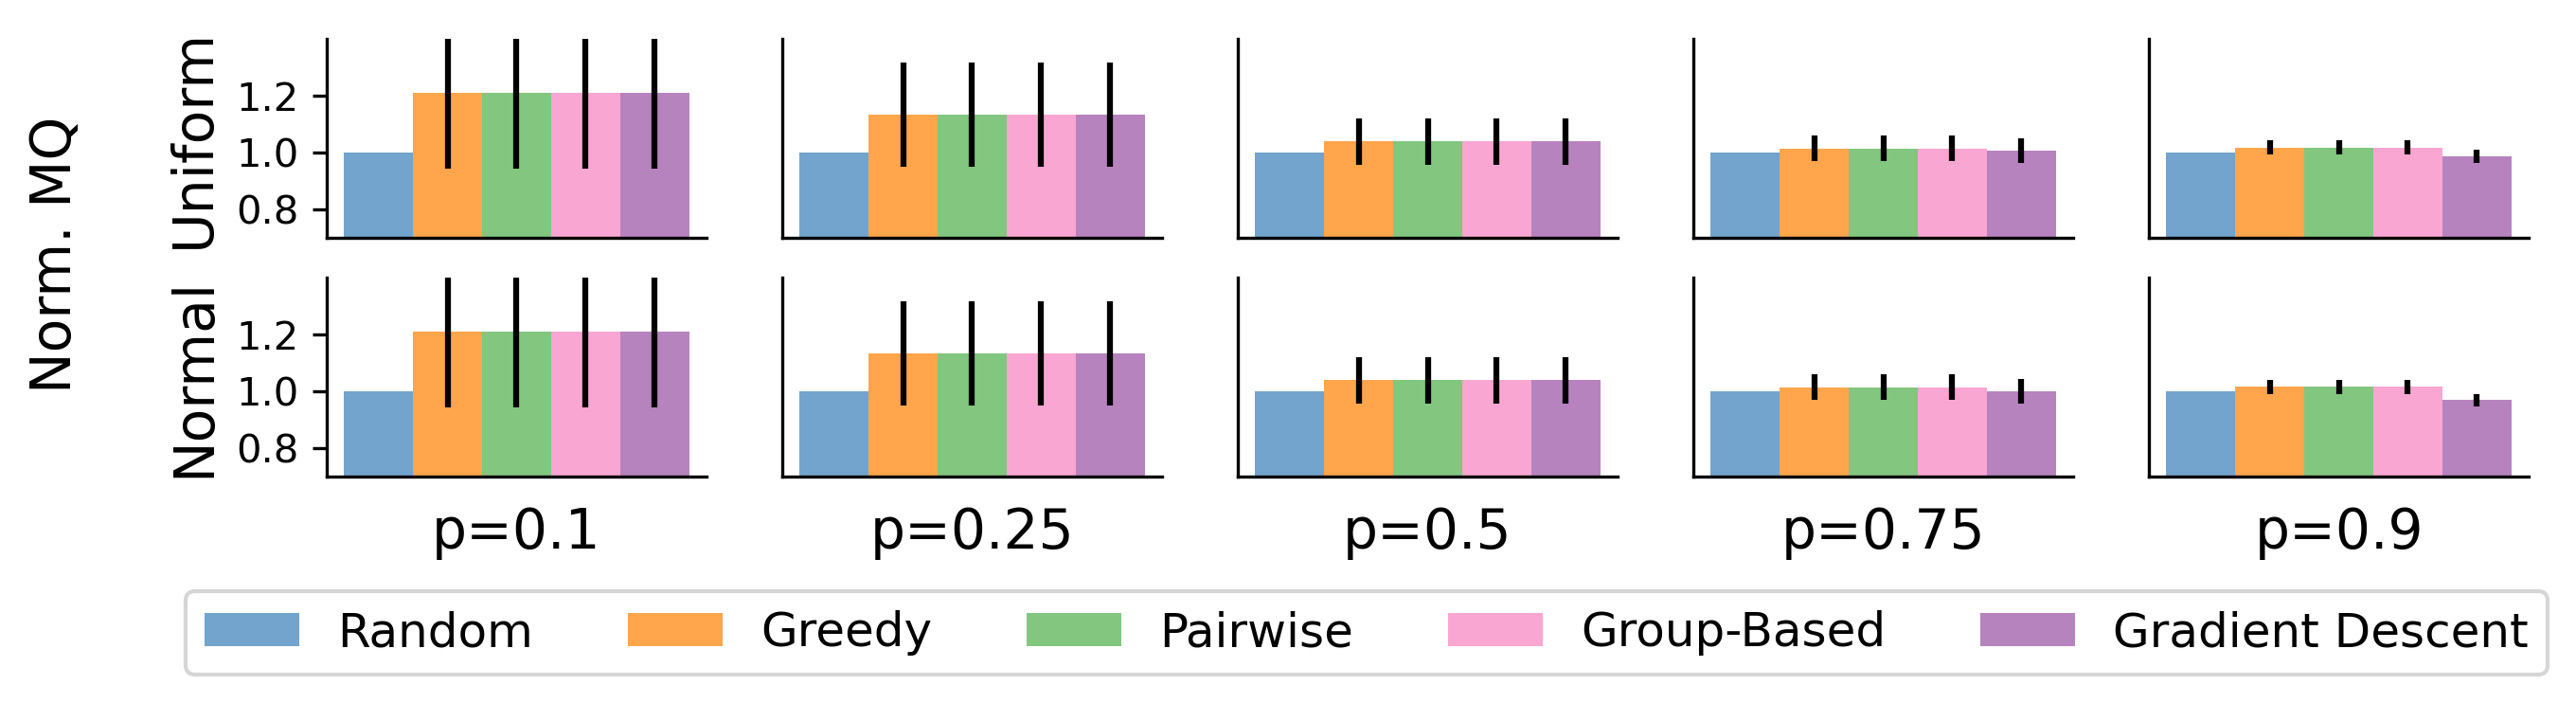

In [71]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Norm. MQ"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.7,1.4] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2],[0.8,1.0,1.2]] for i in range(5)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/policy_comparison.pdf",dpi=300, bbox_inches='tight')

In [69]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_matches'.format(method)][1]/((len(results))**.5) for method in methods]

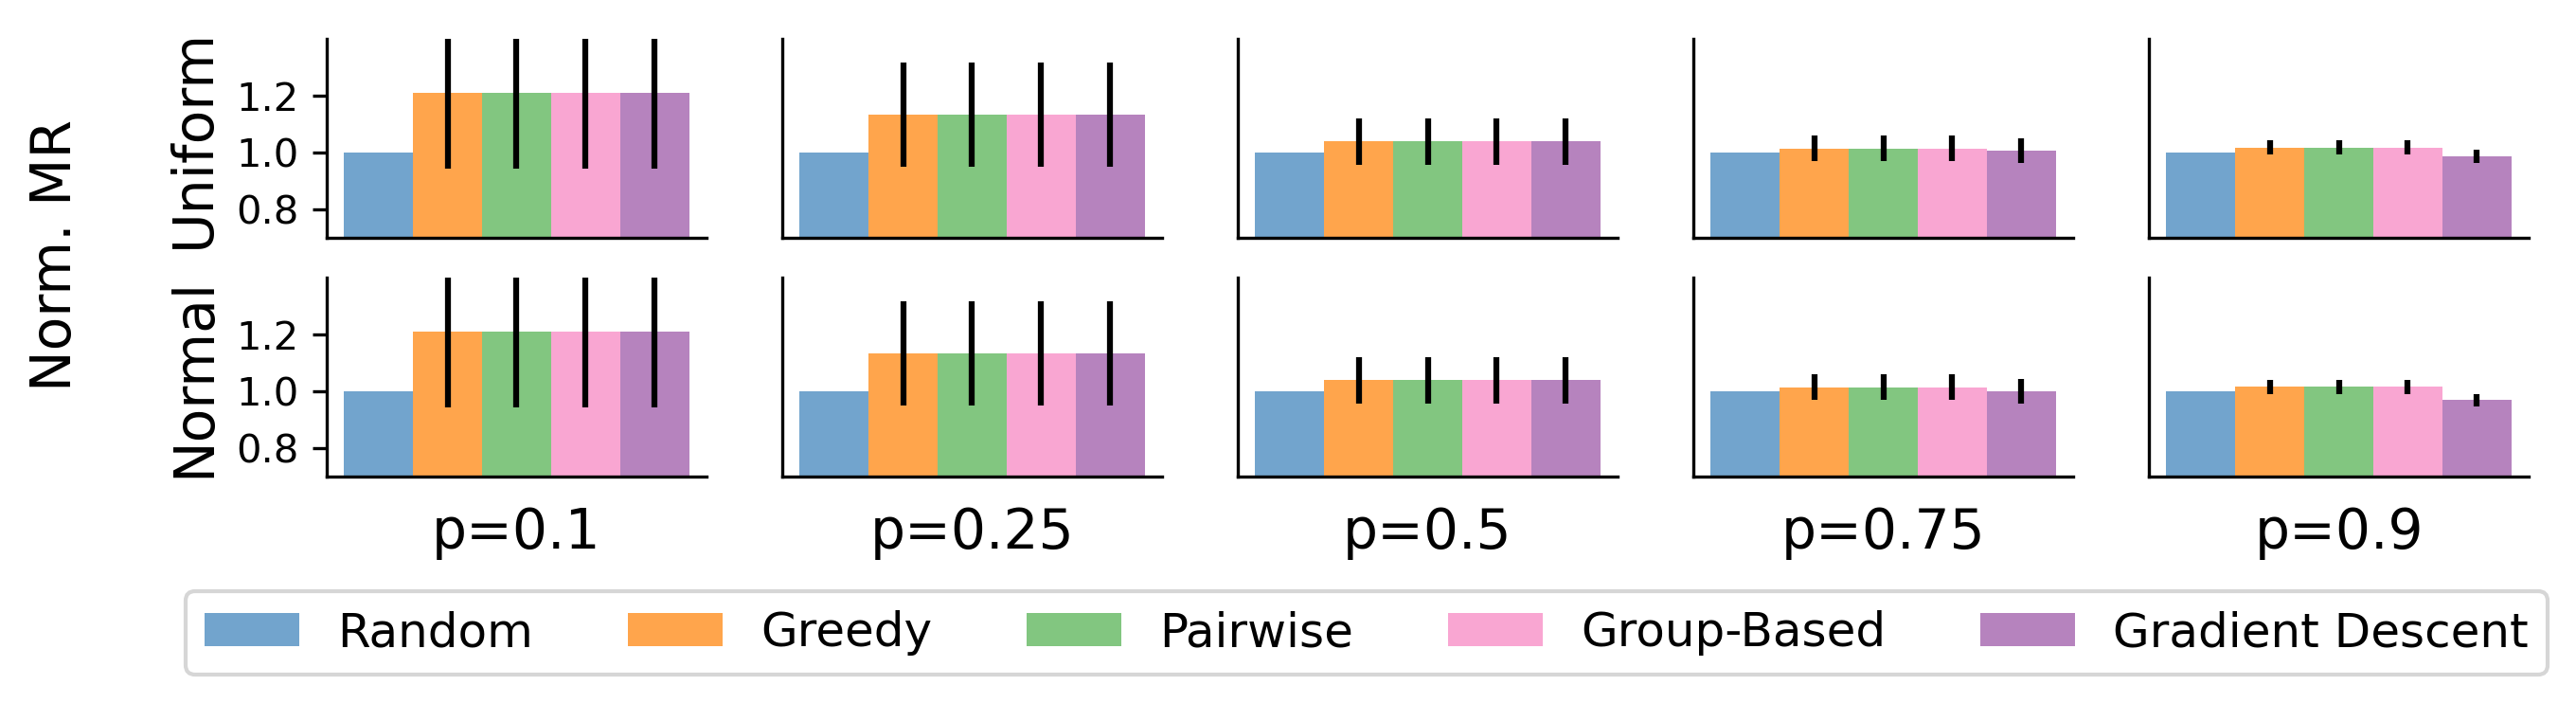

In [70]:
plot_dimensions = (2,5)
x_labels = [["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Uniform","","","",""],["Normal","","","",""]]
sup_y_label = "Norm. MR"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.7,1.4] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2],[0.8,1.0,1.2]] for i in range(5)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/policy_comparison_matches.pdf",dpi=300, bbox_inches='tight')

In [13]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [10,20,30,40,50,60,70,80]
utility_function = 'uniform'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 10, 'max_menu_size': 50, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = np.argmax([aggregate_data['{}_utilities'.format(method)][0] for method in methods])

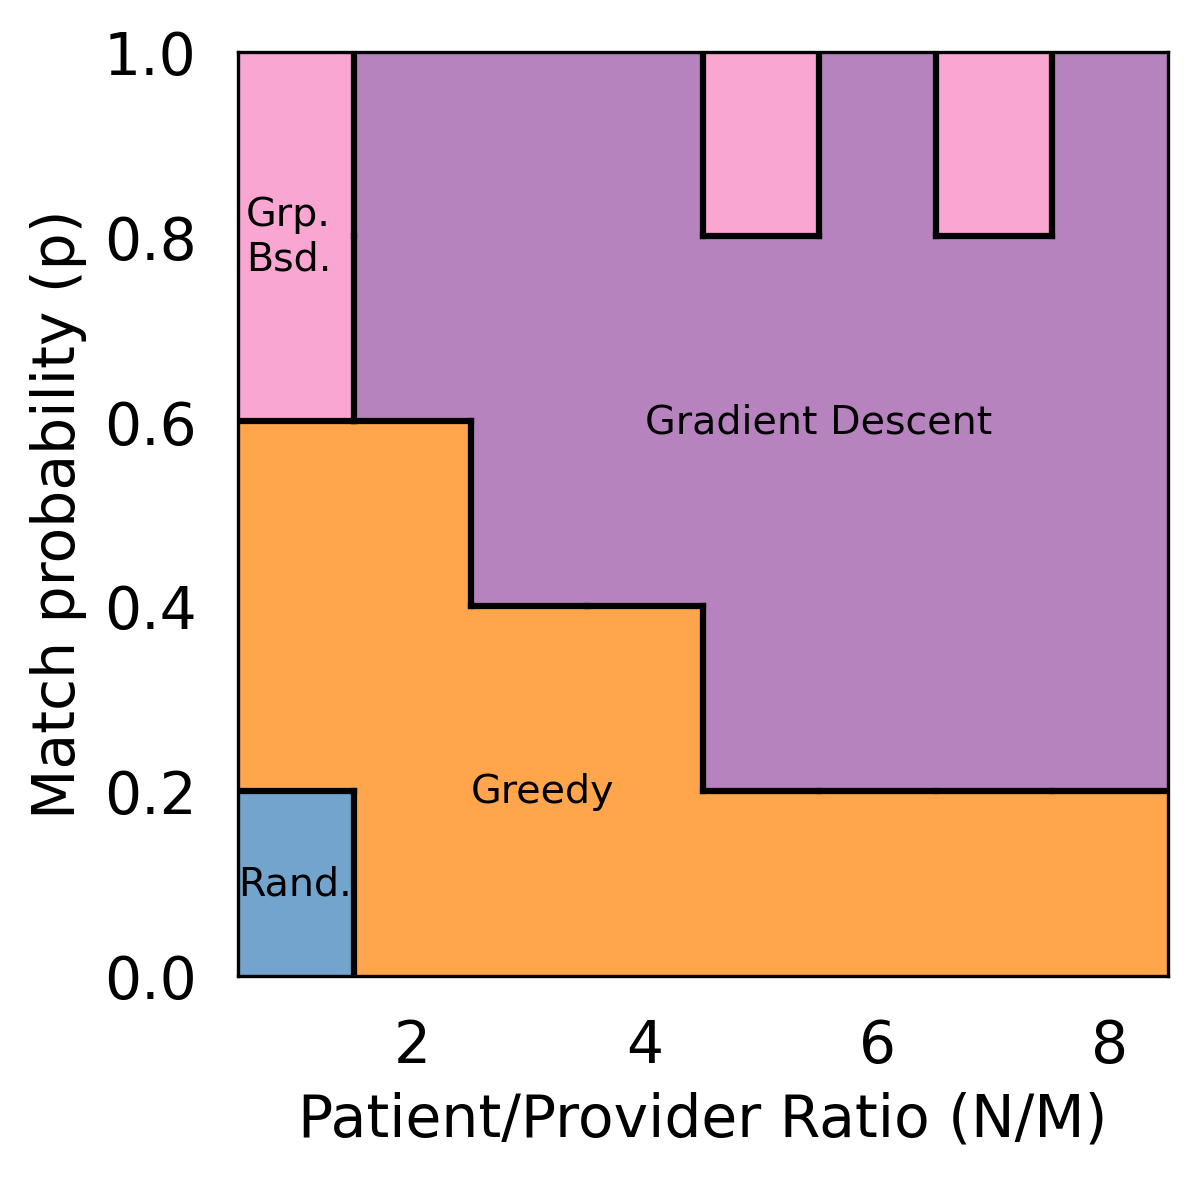

In [14]:
plt.figure(figsize=(4,4))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=color_schemes['six_color'][y_value_matrix[j][i]],lw=0)

        if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
            plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
            plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.57,0.8,"Grp.\nBsd.",verticalalignment='center',fontsize=9.5)
plt.text(2.5,0.2,"Greedy",verticalalignment='center',fontsize=9.5)
plt.text(4,0.6,"Gradient Descent",verticalalignment='center',fontsize=9.5)
plt.text(0.5,0.1,"Rand.",verticalalignment='center',fontsize=9.5)
plt.savefig("../../results/figures/phase_diagram.pdf",dpi=300, bbox_inches='tight')

In [15]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [10,20,30,40,50,60,70,80]
utility_function = 'normal'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 10, 'max_menu_size': 50, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = np.argmax([aggregate_data['{}_utilities'.format(method)][0] for method in methods])

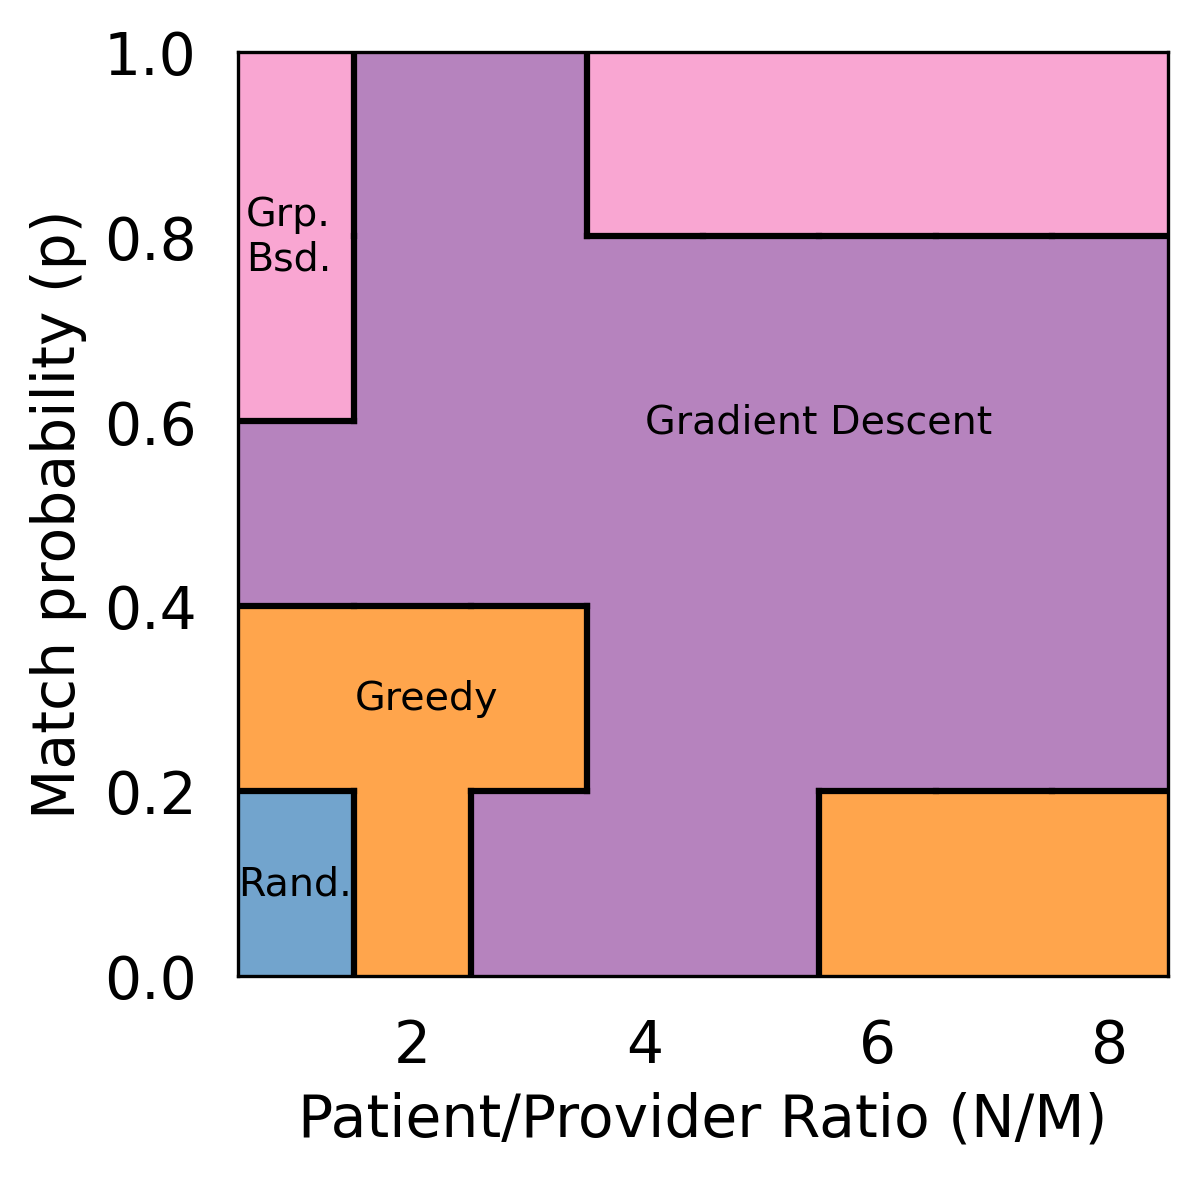

In [16]:
plt.figure(figsize=(4,4))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=color_schemes['six_color'][y_value_matrix[j][i]],lw=0)

        if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
            plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
            plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.57,0.8,"Grp.\nBsd.",verticalalignment='center',fontsize=9.5)
plt.text(1.5,0.3,"Greedy",verticalalignment='center',fontsize=9.5)
plt.text(4,0.6,"Gradient Descent",verticalalignment='center',fontsize=9.5)
plt.text(0.5,0.1,"Rand.",verticalalignment='center',fontsize=9.5)
plt.savefig("../../results/figures/phase_diagram_normal.pdf",dpi=300, bbox_inches='tight')

In [40]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [10,20,30,40,50,60,70,80]
utility_function = 'uniform'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 10, 'max_menu_size': 50, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        method_vals = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = aggregate_data['{}_matches'.format('gradient_descent_fast')][0]/aggregate_data['{}_matches'.format('greedy')][0]
cmap = cm.get_cmap('viridis')
norm = Normalize(vmin=np.min(y_value_matrix), vmax=1.0)
colors = cmap(np.array(norm(y_value_matrix)))

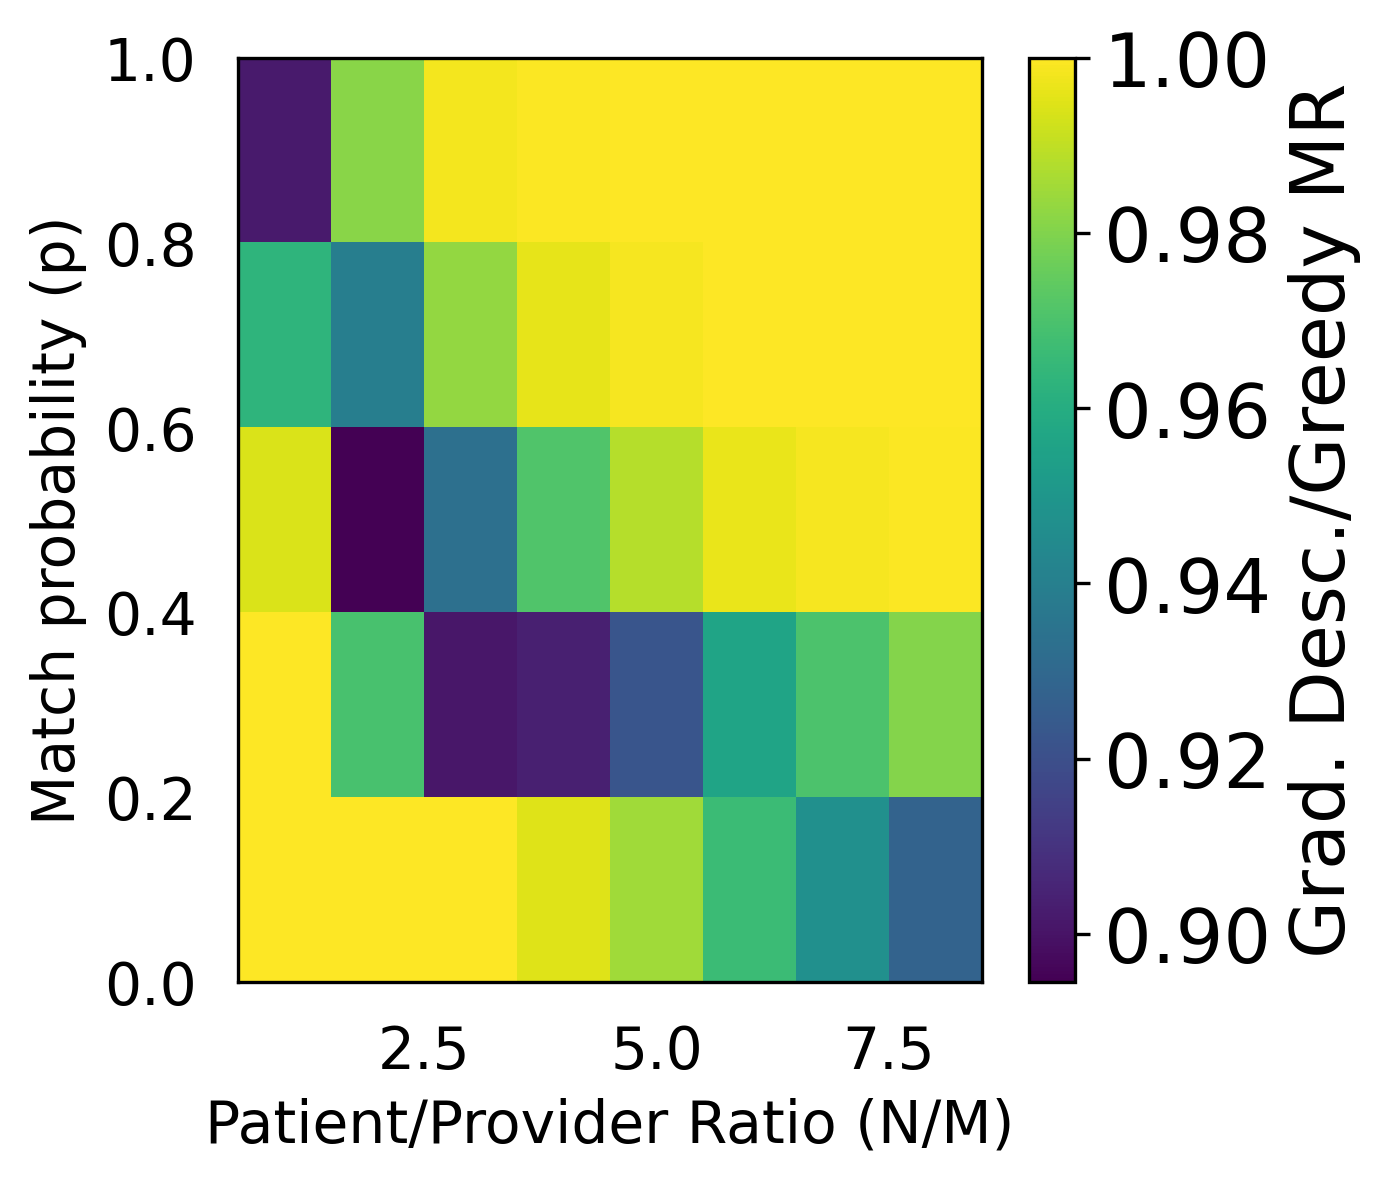

In [37]:
plt.figure(figsize=(4,4))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=colors[j][i],lw=0)

        # if i<len(top_choice_probs)-1 and y_value_matrix[j][i]!=y_value_matrix[j][i+1]:
        #     plt.plot([scaled_patients-gaps,scaled_patients+gaps],[top_choice_probs[i]+0.1,top_choice_probs[i]+0.1],color='black')
        # if j<len(num_patients)-1 and y_value_matrix[j][i]!=y_value_matrix[j+1][i]:
        #     plt.plot([scaled_patients+gaps,scaled_patients+gaps],[top_choice_probs[i]-0.1,top_choice_probs[i]+0.1],color='black')
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.text(4,0.6,"Greedy",verticalalignment='center',fontsize=9.5)
# plt.text(0.5,0.1,"Rand.",verticalalignment='center',fontsize=9.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Grad. Desc./Greedy MR')
plt.savefig("../../results/figures/phase_diagram_match.pdf",dpi=300, bbox_inches='tight')

In [34]:
top_choice_probs = [0.1,0.3,0.5,0.7,0.9]
num_patients = [10,20,30,40,50,60,70,80]
utility_function = 'normal'
dataset = "providers_patients"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(8)]

baseline_params = {'num_patients': 10, 'num_providers': 10, 'max_menu_size': 50, 'utility_function': utility_function, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        method_vals = [aggregate_data['{}_matches'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = aggregate_data['{}_matches'.format('gradient_descent_fast')][0]/aggregate_data['{}_matches'.format('greedy')][0]
cmap = cm.get_cmap('viridis')
norm = Normalize(vmin=np.min(y_value_matrix), vmax=1.0)
colors = cmap(np.array(norm(y_value_matrix)))

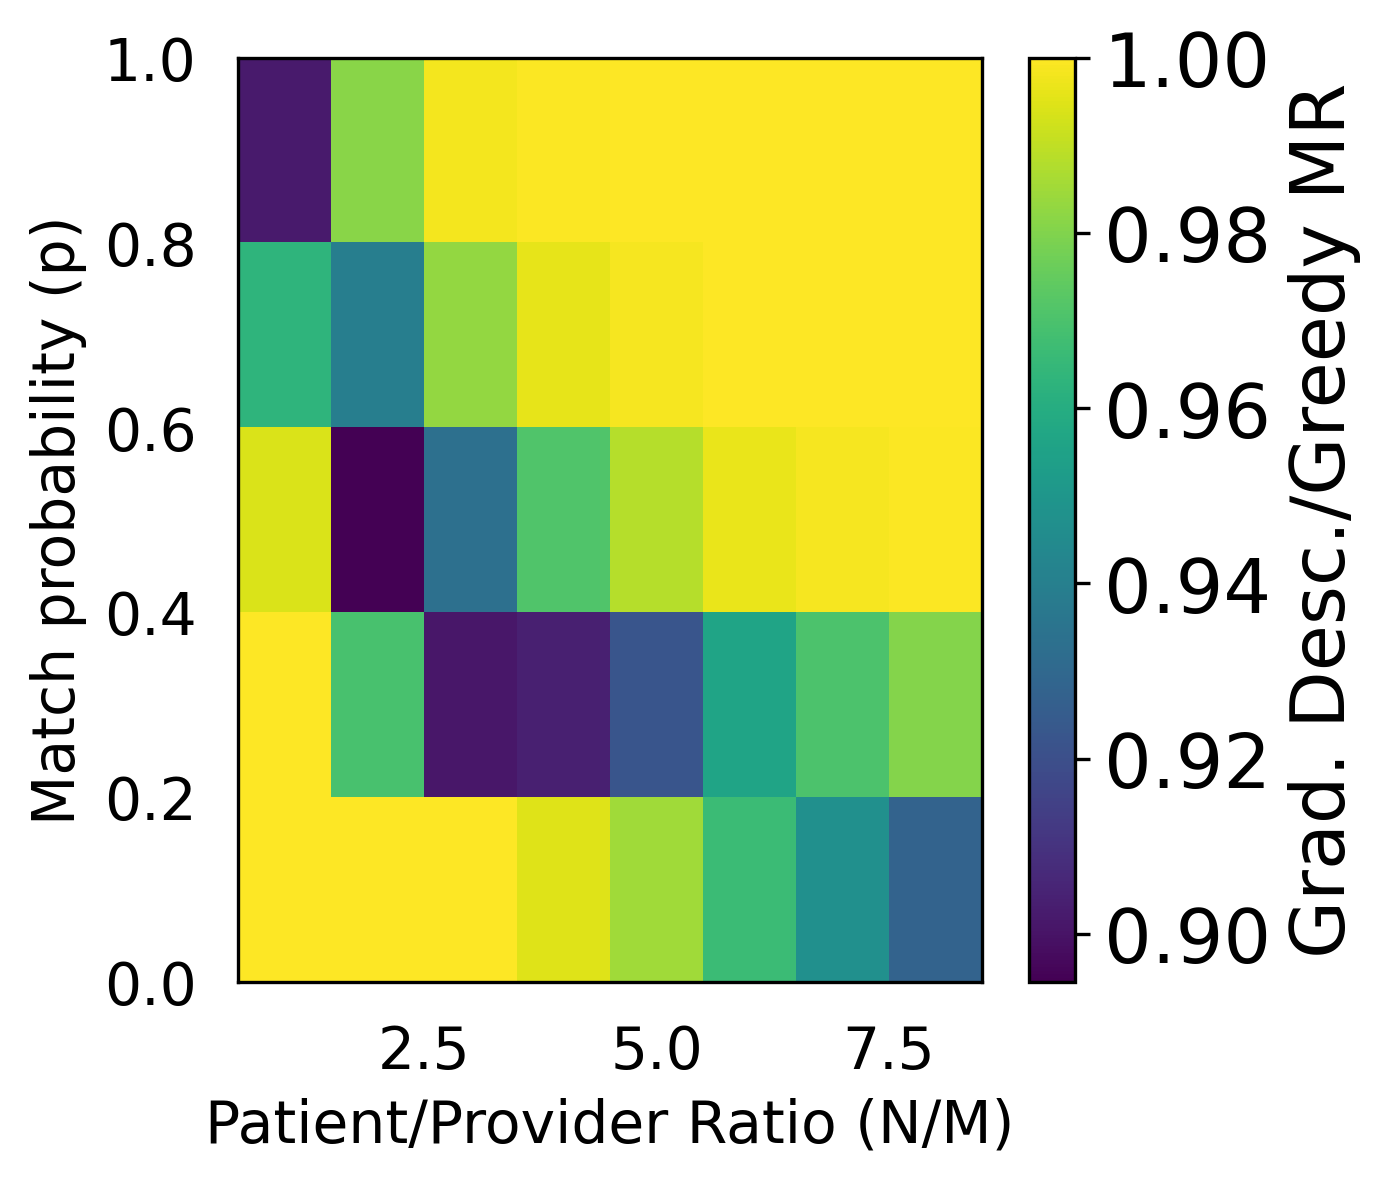

In [38]:
plt.figure(figsize=(4,4))
reference_patients = num_patients[0]
gaps = 1/2
for i in range(len(top_choice_probs)):
    for j in range(len(num_patients)):
        scaled_patients = num_patients[j]/reference_patients
        x = [scaled_patients-gaps,scaled_patients-gaps,scaled_patients+gaps,scaled_patients+gaps,scaled_patients-gaps]
        y = [top_choice_probs[i]-0.1,top_choice_probs[i]+0.1,top_choice_probs[i]+0.1,top_choice_probs[i]-0.1,top_choice_probs[i]-0.1]
        plt.fill(x, y, color=colors[j][i],lw=0)
    plt.ylim([0,1])
    plt.xlim([0.5,8.5])
plt.tick_params(axis='both',which='both',length=0,pad=10)
ax = plt.gca()  # Get the current Axes object
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

plt.xlabel("Patient/Provider Ratio (N/M)",fontsize=14)
plt.ylabel("Match probability (p)",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Grad. Desc./Greedy MR')
plt.savefig("../../results/figures/phase_diagram_normal_matches.pdf",dpi=300, bbox_inches='tight')

### Assumption Plots

In [74]:
top_choice_prob = 0.5
assumption_relaxations = [["misspecified_theta_0.0","misspecified_theta_0.05","misspecified_theta_0.1","misspecified_theta_0.2"],["varied_p_0.0","varied_p_0.05","varied_p_0.1","varied_p_0.2"]]
utility_function = 'uniform'
dataset = "assumptions"

y_value_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50,
                   'utility_function': utility_function, 'top_choice_prob': top_choice_prob}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['assumption_relaxation'] = assumption_relaxations[i][j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

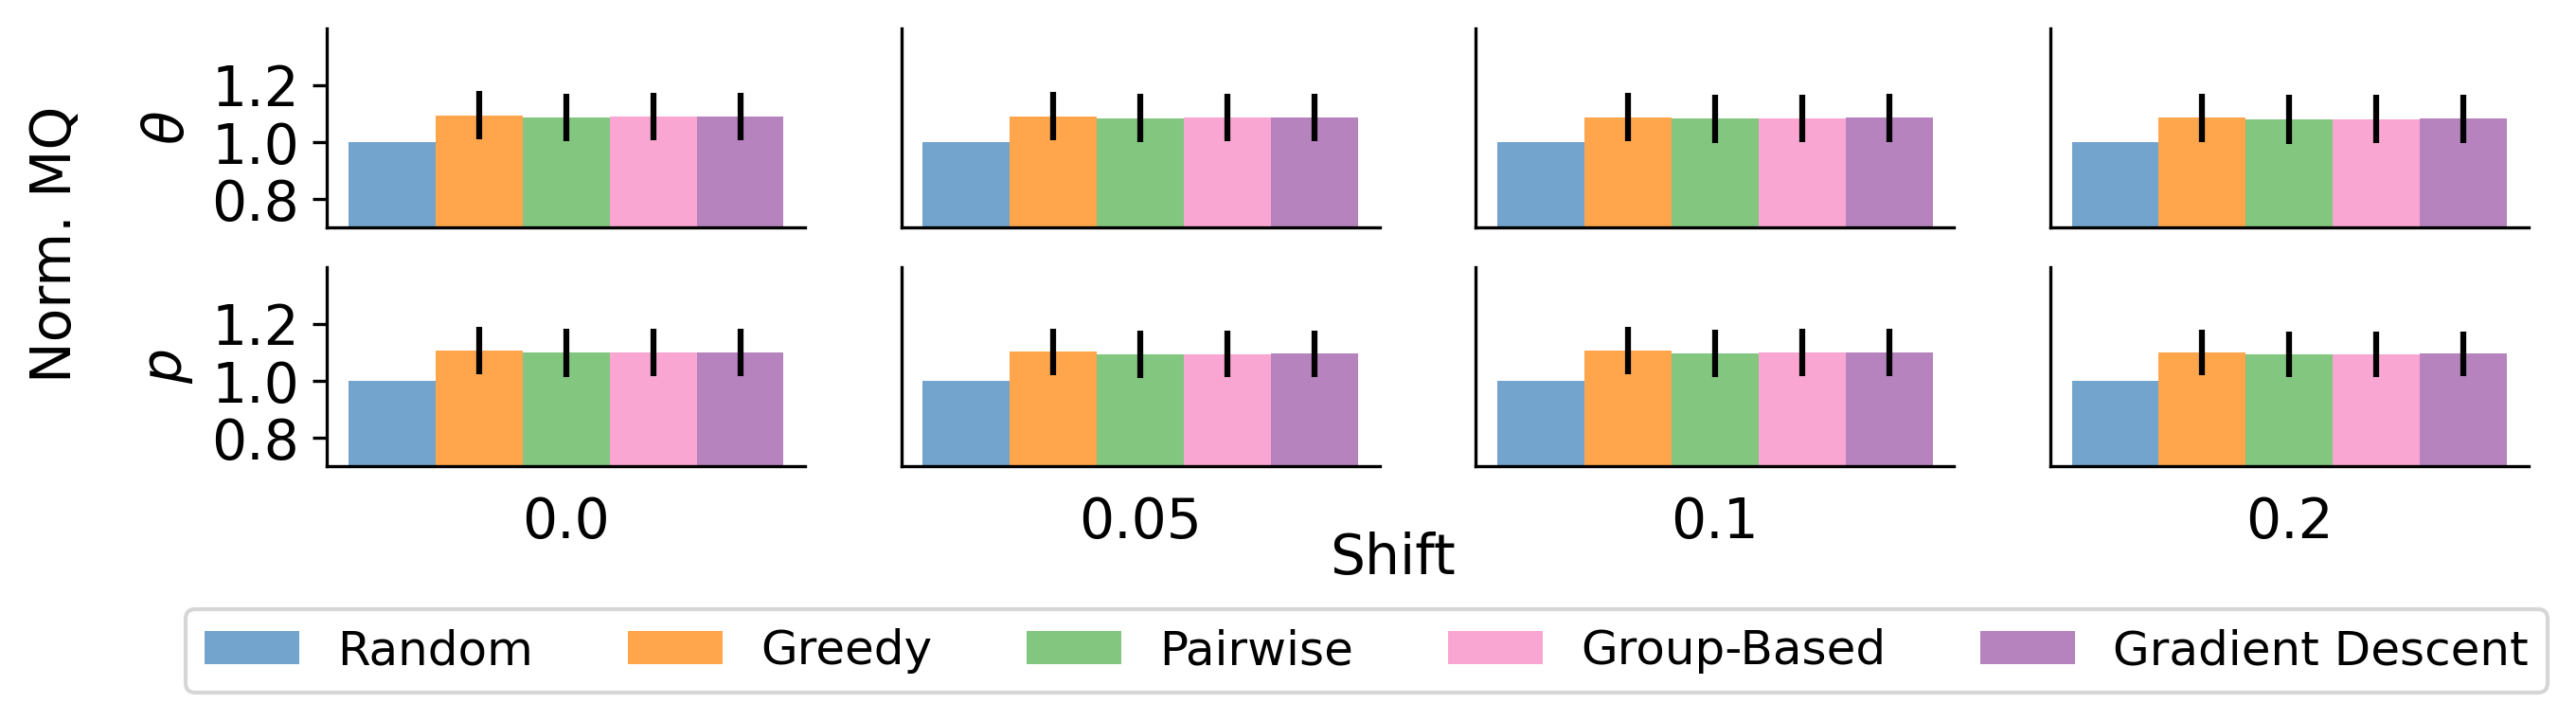

In [75]:
plot_dimensions = (2,4)
x_labels = [["","","",""],["0.0","0.05","0.1","0.2"]]
y_labels = [["$\\theta$","","",""],["$p$","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = "Shift"

overall_format = {'figsize':(10, 2),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(4)] for i in range(2)],
    'y_lim': [[[0.7,1.4] for i in range(4)] for i in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2],[0.8,1.0,1.2]] for i in range(4)] for i in range(2)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.1)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(4):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.915,-0.1)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/theta_p_shift.pdf",dpi=300, bbox_inches='tight')

In [76]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
assumption_relaxations = ["dynamic_lp","",""]
order = ["custom","proportional","custom"]
provider_capacity = [1,1,2]
dataset = "assumptions"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(3)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(3)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0, 'provider_capacity': 2,'utility_function': 'uniform'}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['top_choice_prob'] = top_choice_probs[j]
        baseline_params['order'] = order[i]
        baseline_params['provider_capacity'] = provider_capacity[i]
        baseline_params['assumption_relaxation'] = assumption_relaxations[i]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        if i == 0:
            y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods + ['lp_dynamic']]
            y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods + ['lp_dynamic']]
        else:
            y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
            y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

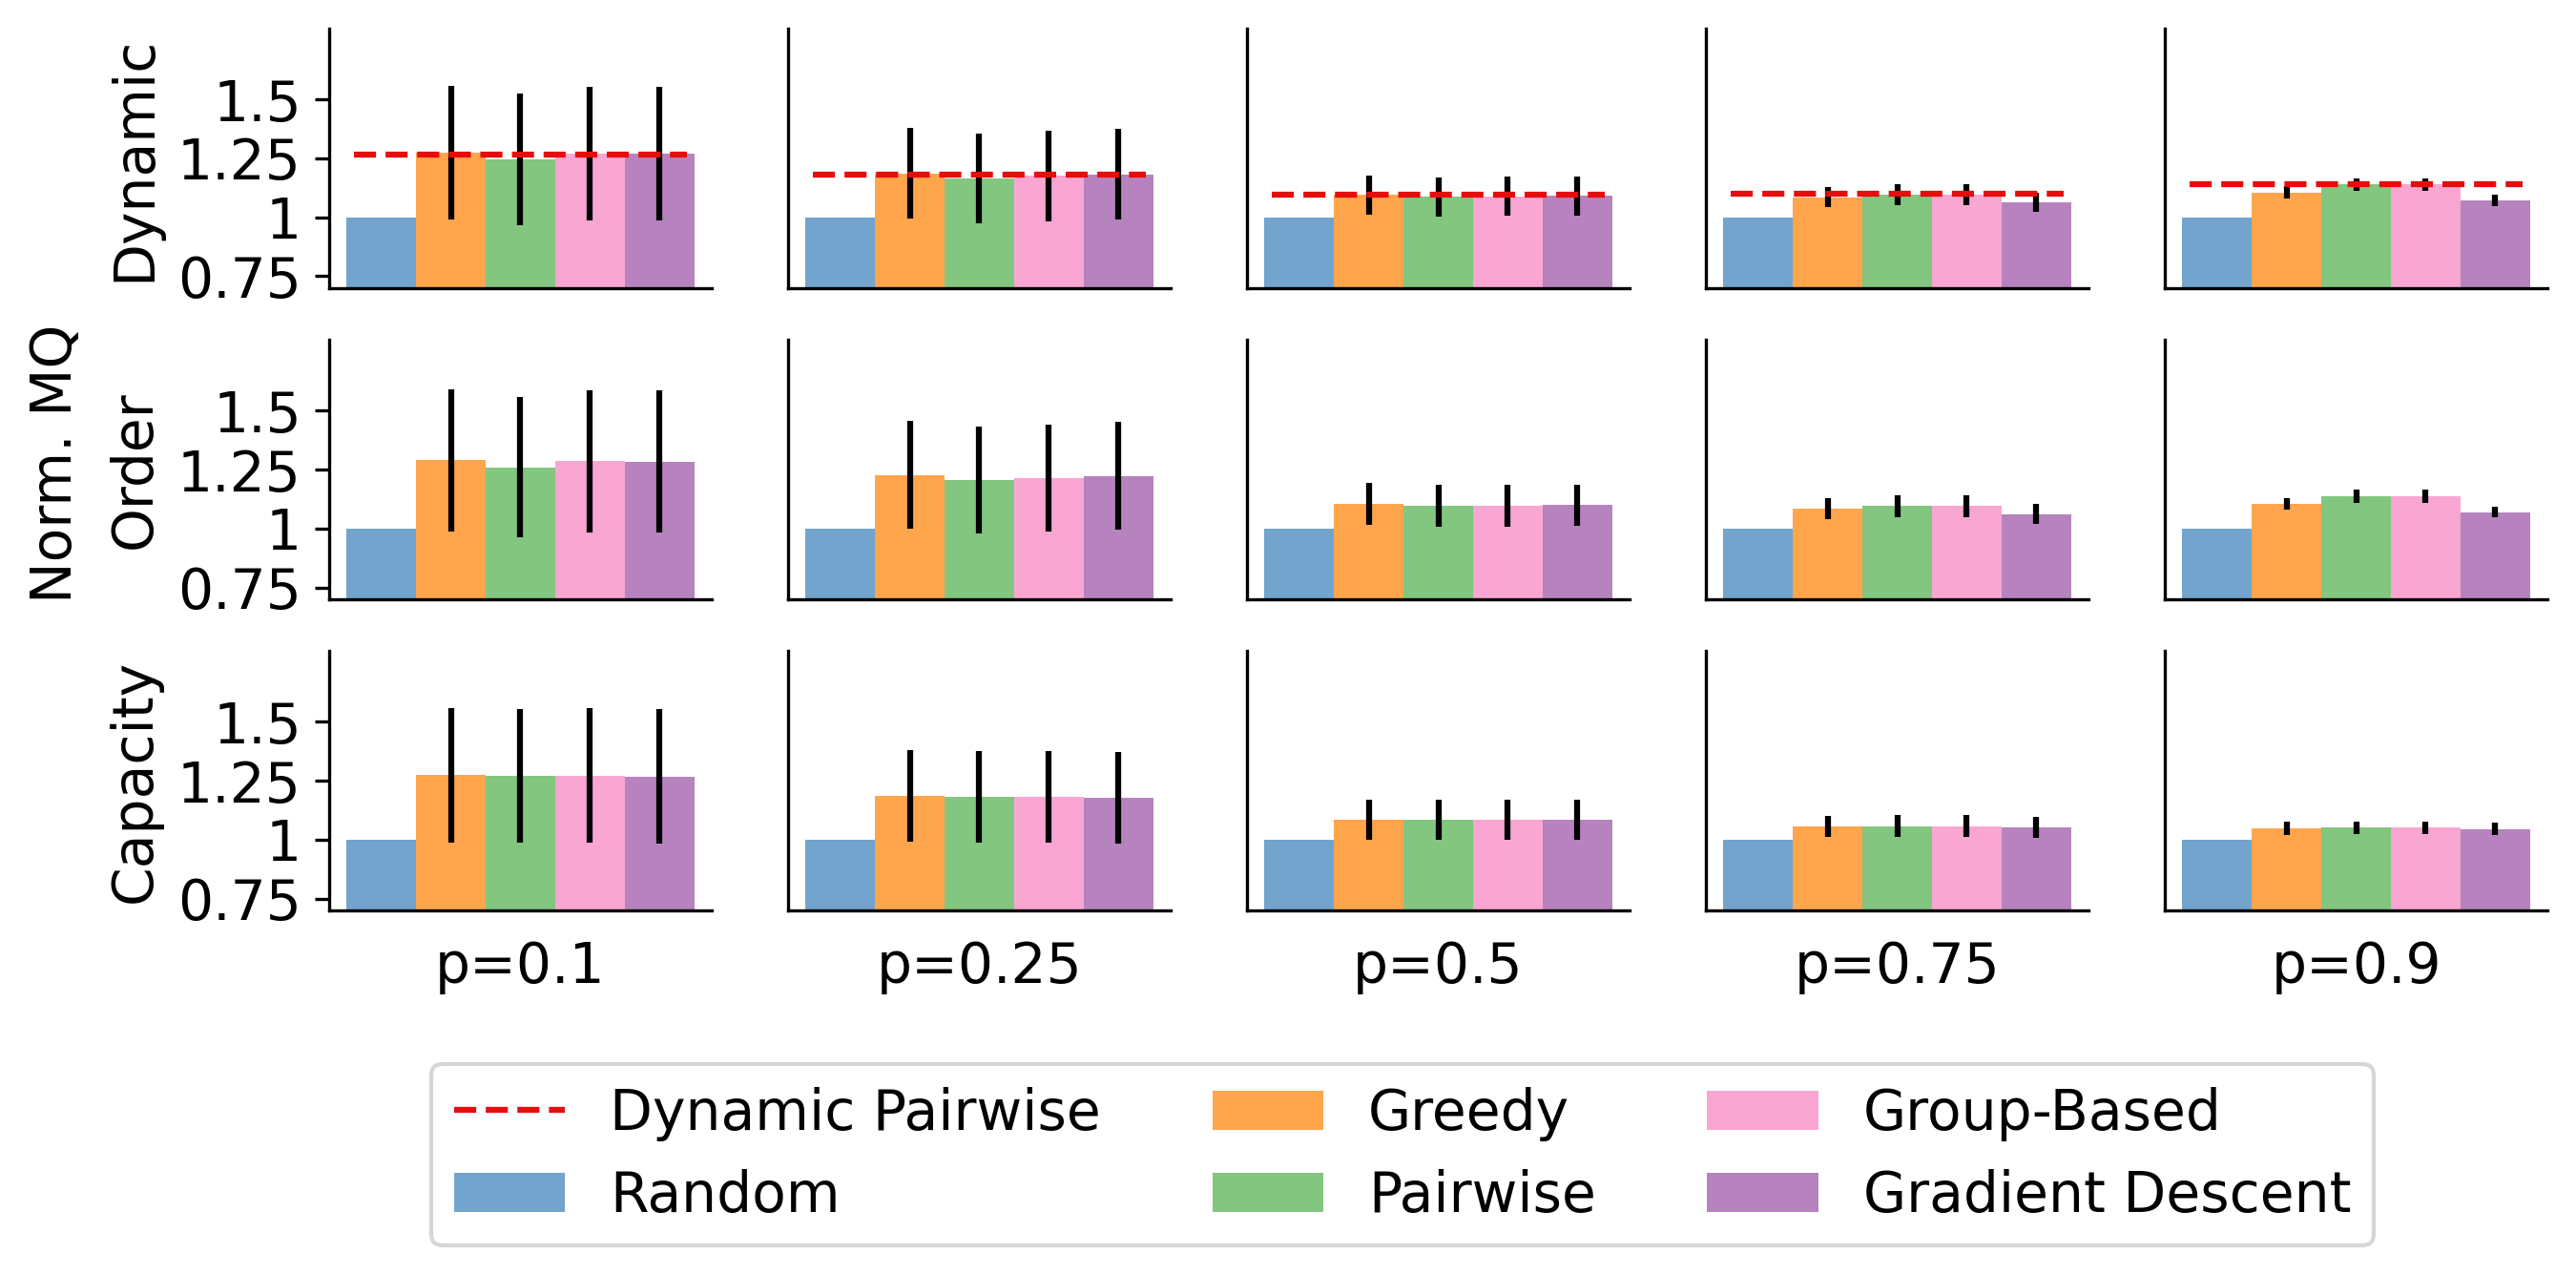

In [77]:
plot_dimensions = (3,5)
x_labels = [["","","","",""],["","","","",""],["p=0.1","p=0.25","p=0.5","p=0.75","p=0.9"]]
y_labels = [["Dynamic","","","",""],["Order","","","",""],["Capacity","","","",""]]
sup_y_label = "Norm. MQ"

overall_format = {'figsize':(10, 4),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(3)],
    'y_lim': [[[0.7,1.8] for i in range(5)] for j in range(3)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.75,1,1.25,1.5],[0.75,1,1.25,1.5]] for i in range(5)] for i in range(3)],
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(3):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)
        if i == 0:
            ax[i,j].hlines(y_value_matrix[i][j][-1],-0.1,1.1,linestyles='dashed',label='Dynamic Pairwise',color=np.array([0.9,0.05,0.05,1.0]))


handles, labels = ax[0,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0),fontsize=14)
fig.savefig("../../results/figures/assumptions.pdf",dpi=300, bbox_inches='tight')

### Fairness Plots

In [48]:
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']
dataset = "policy_comparison"

x_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['utility_function'] = utility_functions[i]
        baseline_params['top_choice_prob'] = top_choice_probs[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        x_value_matrix[i][j] = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [49]:
np.array(x_value_matrix)[:,:,3]/(np.max(np.array(x_value_matrix),axis=2))

array([[0.99466078, 0.98010188, 0.99544937, 0.99716247, 1.        ],
       [1.        , 1.        , 0.96757065, 0.68538899, 0.91501409]])

In [50]:
np.array(y_value_matrix)[:,:,3]/(np.max(np.array(y_value_matrix),axis=2))

array([[0.99680509, 0.98989283, 0.99425218, 1.        , 1.        ],
       [1.        , 1.        , 0.99370547, 0.96753086, 1.        ]])

### Number of Providers

In [10]:
ratio_y_values = [[] for i in range(len(methods))]
ratio_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'uniform'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        ratio_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [11]:
np.array(ratio_y_values[-1])/np.array(ratio_y_values[1])

array([0.98255896, 1.0442823 , 1.0480751 , 1.04599779])

In [12]:
np.array(ratio_y_values)[:,-1][-1]/np.array(ratio_y_values)[:,-1][-2]

1.0459113465605736

In [13]:
np.max(np.array(ratio_y_values),axis=1)/np.min(np.array(ratio_y_values),axis=1)

array([1.        , 1.01693183, 1.04354529, 1.0157473 , 1.05028858])

In [14]:
ratio_y_values_normal = [[] for i in range(len(methods))]
ratio_confidences_normal = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'normal'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values_normal[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        ratio_confidences_normal[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [15]:
np.array(ratio_y_values_normal)[:,-1][-1]/np.array(ratio_y_values_normal)[:,-1][-4]

1.0914437700636244

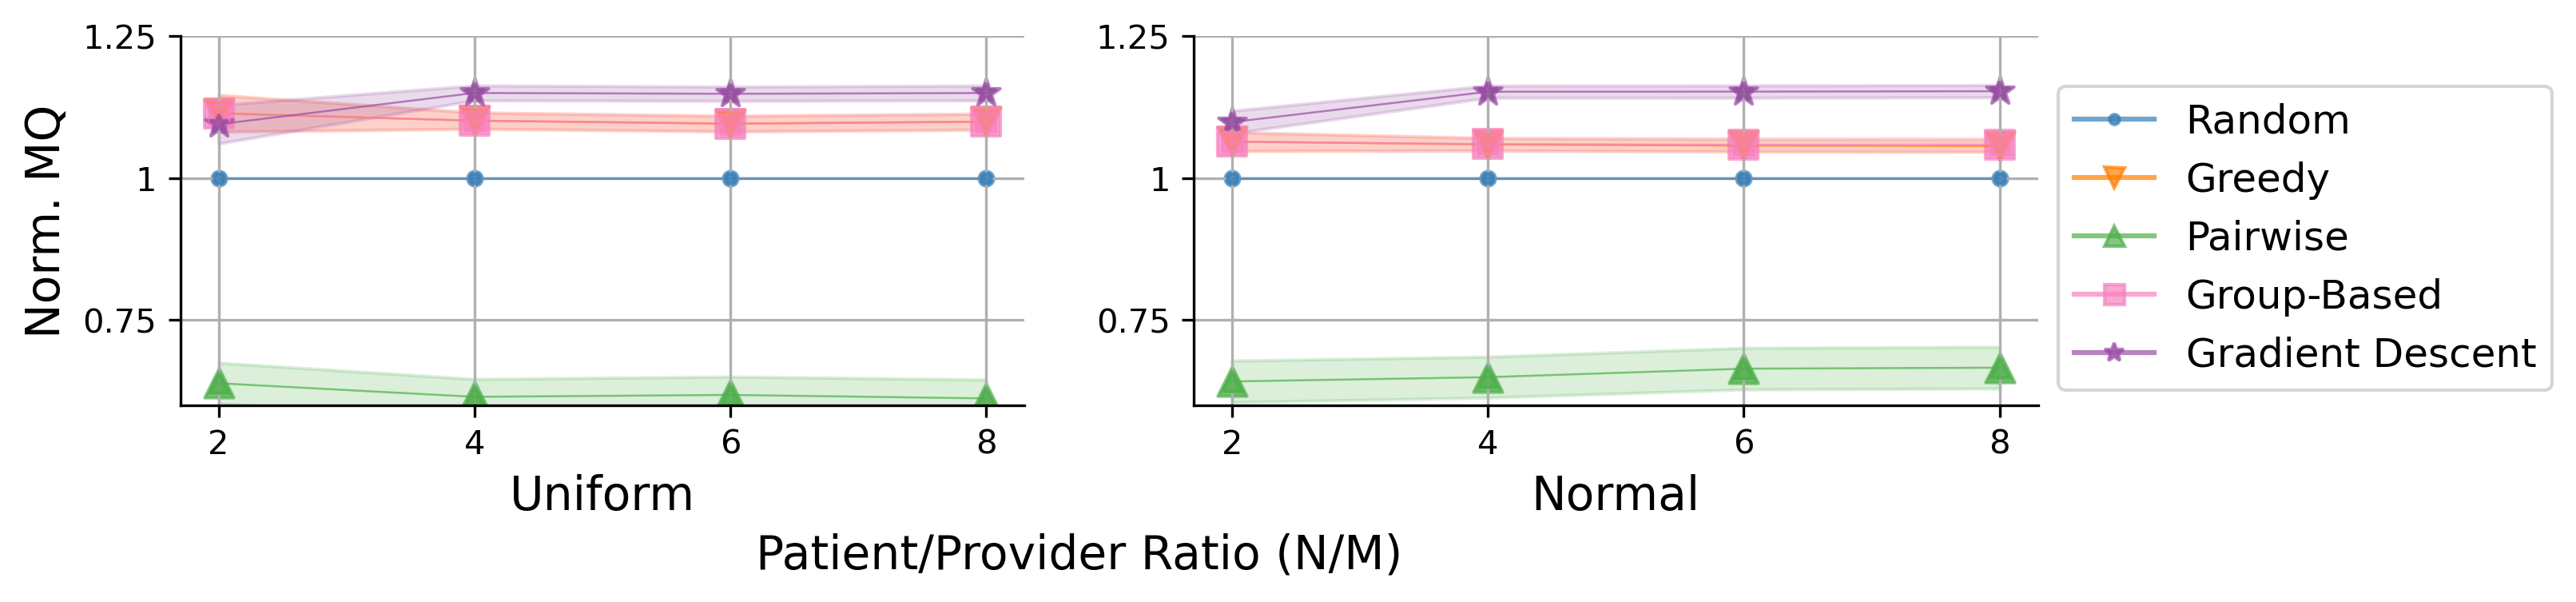

In [22]:
plot_dimensions = (1,2)
x_labels = [["Uniform","Normal"]]
sup_x_label = "Patient/Provider Ratio (N/M)"
y_labels = [["Norm. MQ",""]]
overall_format = {'figsize':(10,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values],[x_values,x_values]]],
    'y_ticks': [[[[0.75,1,1.25],[0.75,1,1.25]],[[0.75,1,1.25],[0.75,1,1.25]]]],
    'y_lim': [[[0.6,1.25],[0.6,1.25]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.25)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,ratio_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,[None for i in range(len(method_labels))],line_format)

plot_line(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,ratio_confidences_normal,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,[None for i in range(len(method_labels))],line_format)


legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 1, 'bbox_to_anchor': (0.9,0.1), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/vary_providers_patients.pdf",dpi=300, bbox_inches='tight')

In [58]:
ratio_y_values = [[] for i in range(len(methods))]
ratio_confidences = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'uniform'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values[method].append(aggregate_data['{}_matches'.format(methods[method])][0])
        ratio_confidences[method].append(aggregate_data['{}_matches'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


In [59]:
ratio_y_values_normal = [[] for i in range(len(methods))]
ratio_confidences_normal = [[] for i in range(len(methods))]
baseline_params = {'num_providers': 25,'max_menu_size': 500, 'utility_function': 'normal'}
dataset = "providers_patients"
x_values = [2,4,6,8]
for i in range(len(x_values)):
    baseline_params['num_patients'] = x_values[i]*25

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(method_labels)):
        ratio_y_values_normal[method].append(aggregate_data['{}_matches'.format(methods[method])][0])
        ratio_confidences_normal[method].append(aggregate_data['{}_matches'.format(methods[method])][1]/len(results)**.5)

15
15
15
15


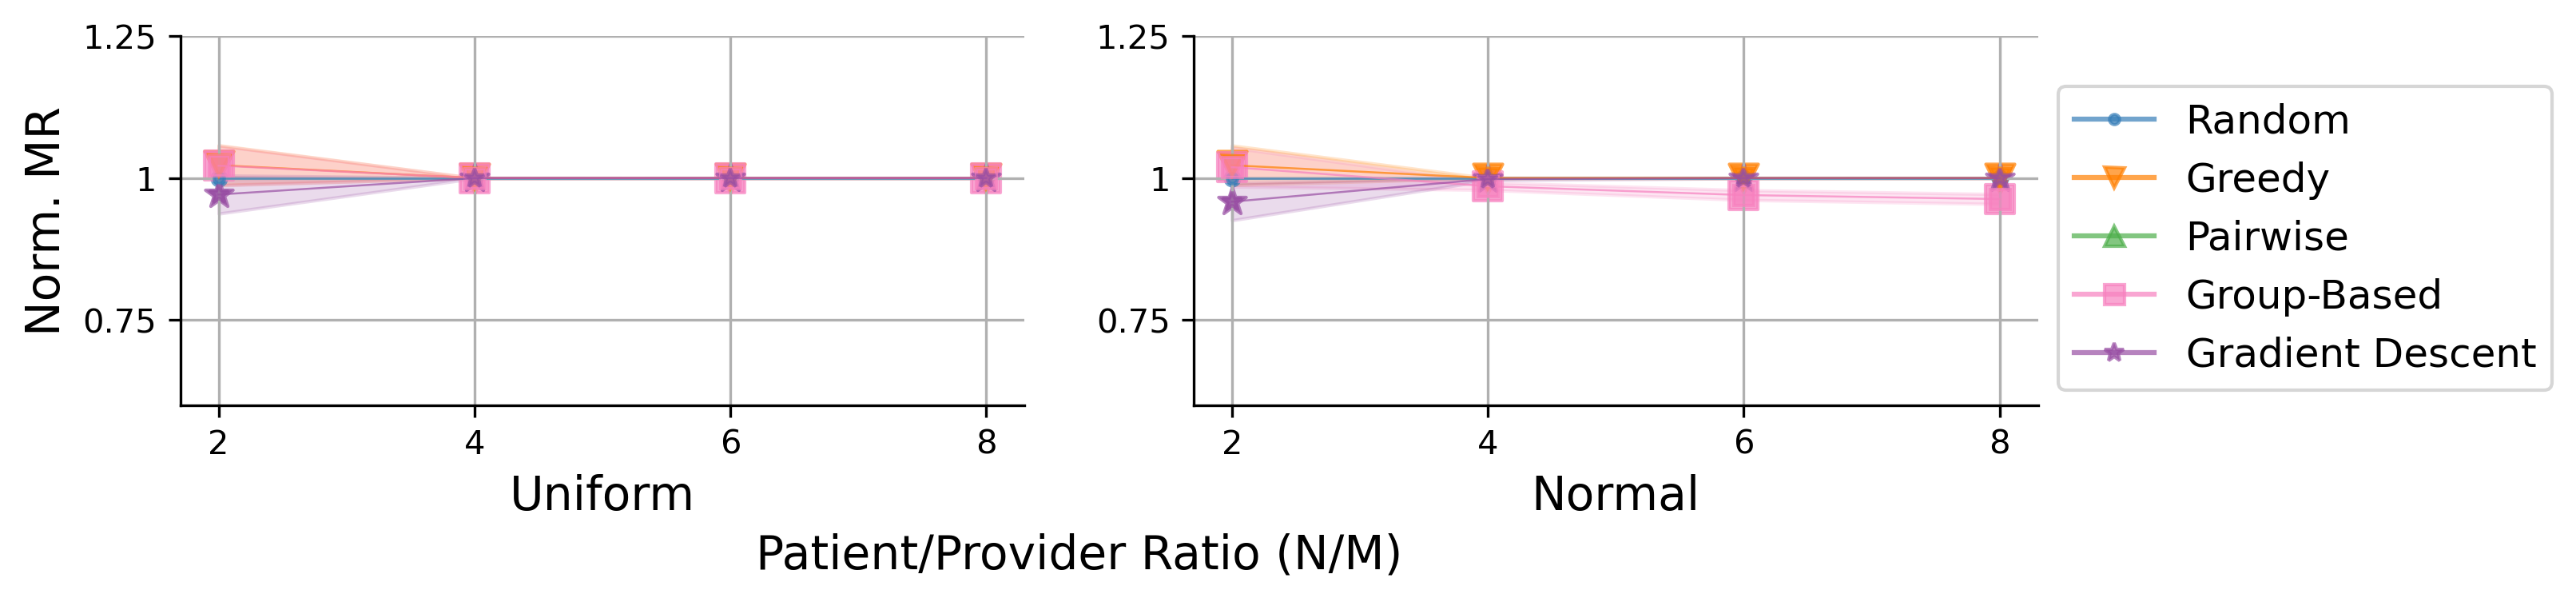

In [61]:
plot_dimensions = (1,2)
x_labels = [["Uniform","Normal"]]
sup_x_label = "Patient/Provider Ratio (N/M)"
y_labels = [["Norm. MR",""]]
overall_format = {'figsize':(10,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values],[x_values,x_values]]],
    'y_ticks': [[[[0.75,1,1.25],[0.75,1,1.25]],[[0.75,1,1.25],[0.75,1,1.25]]]],
    'y_lim': [[[0.6,1.25],[0.6,1.25]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels,sup_x_label=sup_x_label,sup_x_label_loc=-0.25)

line_format = {'color_palette': 'six_color', 'size': 75}
plot_line(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,ratio_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(ratio_y_values))],ratio_y_values,[None for i in range(len(method_labels))],line_format)

plot_line(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,ratio_confidences_normal,method_labels,line_format)
plot_scatter(ax[0][1],[x_values for i in range(len(ratio_y_values))],ratio_y_values_normal,[None for i in range(len(method_labels))],line_format)


legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 1, 'bbox_to_anchor': (0.9,0.1), 'show_point': True}
create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/vary_providers_patients_matches.pdf",dpi=300, bbox_inches='tight')

### Other Choice Models

In [94]:
exit_options = [0.1,0.25,0.5,0.75]
choice_models = ['mnl','threshold']
dataset = "misspecification"

y_value_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(4)] for i in range(2)]

baseline_params = {'num_patients': 25, 'num_providers': 25,'top_choice_prob': 0.5, 'true_top_choice_prob': 0.5, 'fairness_weight': 0}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['choice_model'] = choice_models[i]
        baseline_params['exit_option'] = exit_options[j]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

In [95]:
np.min(y_value_matrix[0][0][2:])/y_value_matrix[0][0][1]

1.217504365782899

In [96]:
y_value_matrix[0][-1][3]/y_value_matrix[0][-1][1]

1.0131796806017803

In [97]:
np.min(y_value_matrix[0][-1][2:])/y_value_matrix[0][-1][1]

1.0043694902636433

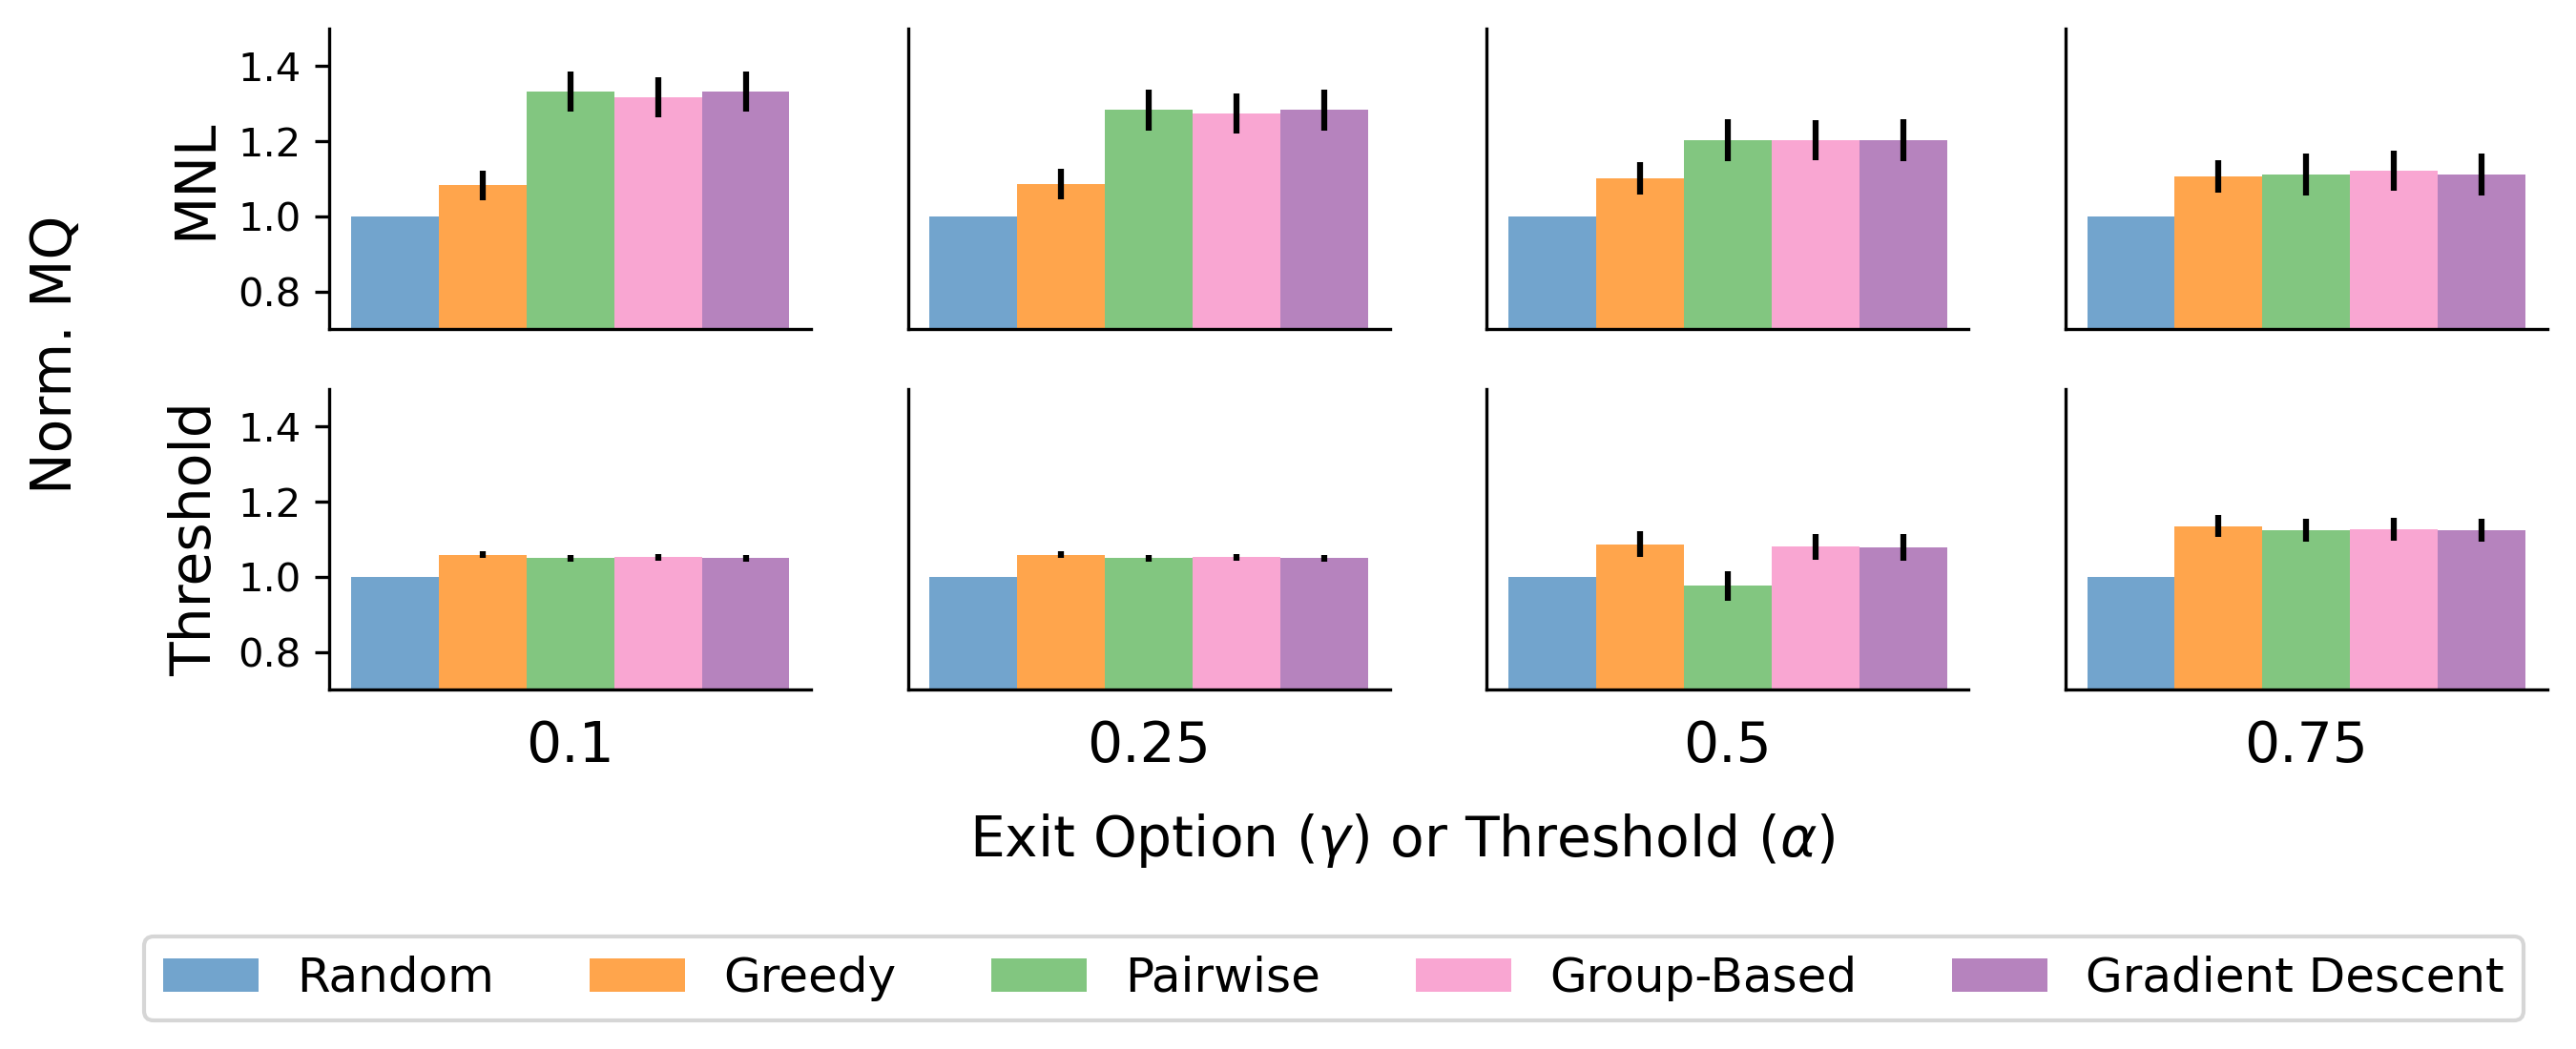

In [98]:
plot_dimensions = (2,4)
x_labels = [["","","",""],["0.1","0.25","0.5","0.75","0.9"]]
y_labels = [["MNL","","",""],["Threshold","","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = "Exit Option ($\\gamma$) or Threshold ($\\alpha$)"

overall_format = {'figsize':(10, 3),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(2)],
    'y_lim': [[[0.7,1.5] for i in range(5)] for j in range(2)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.8,1,1.2,1.4],[0.8,1.0,1.2,1.4]] for i in range(5)] for i in range(2)],

}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.1)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(2):
    for j in range(4):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.9,-0.15)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/other_choice_models.pdf",dpi=300, bbox_inches='tight')

In [105]:
choice_prob = [0.1,0.25,0.5,0.75,0.9]
true_choice_prob = [0.1,0.25,0.5,0.75,0.9][::-1]
dataset = "misspecification"

y_value_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(5)]
y_confidence_matrix = [[[0 for i in range(5)] for i in range(5)] for i in range(5)]

baseline_params = {'num_patients': 25, 'num_providers': 25,'top_choice_prob': 0.5, 'true_top_choice_prob': 0.5, 'fairness_weight': 0, 'choice_model': 'uniform_choice'}
for i in range(len(y_value_matrix)):
    for j in range(len(y_value_matrix[i])):
        baseline_params['top_choice_prob'] = choice_prob[j]
        baseline_params['true_top_choice_prob'] = true_choice_prob[i]

        results = get_results_matching_parameters(dataset,"",baseline_params)
        aggregate_data = aggregate_normalize_data(results,baseline="random")

        y_value_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
        y_confidence_matrix[i][j] = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

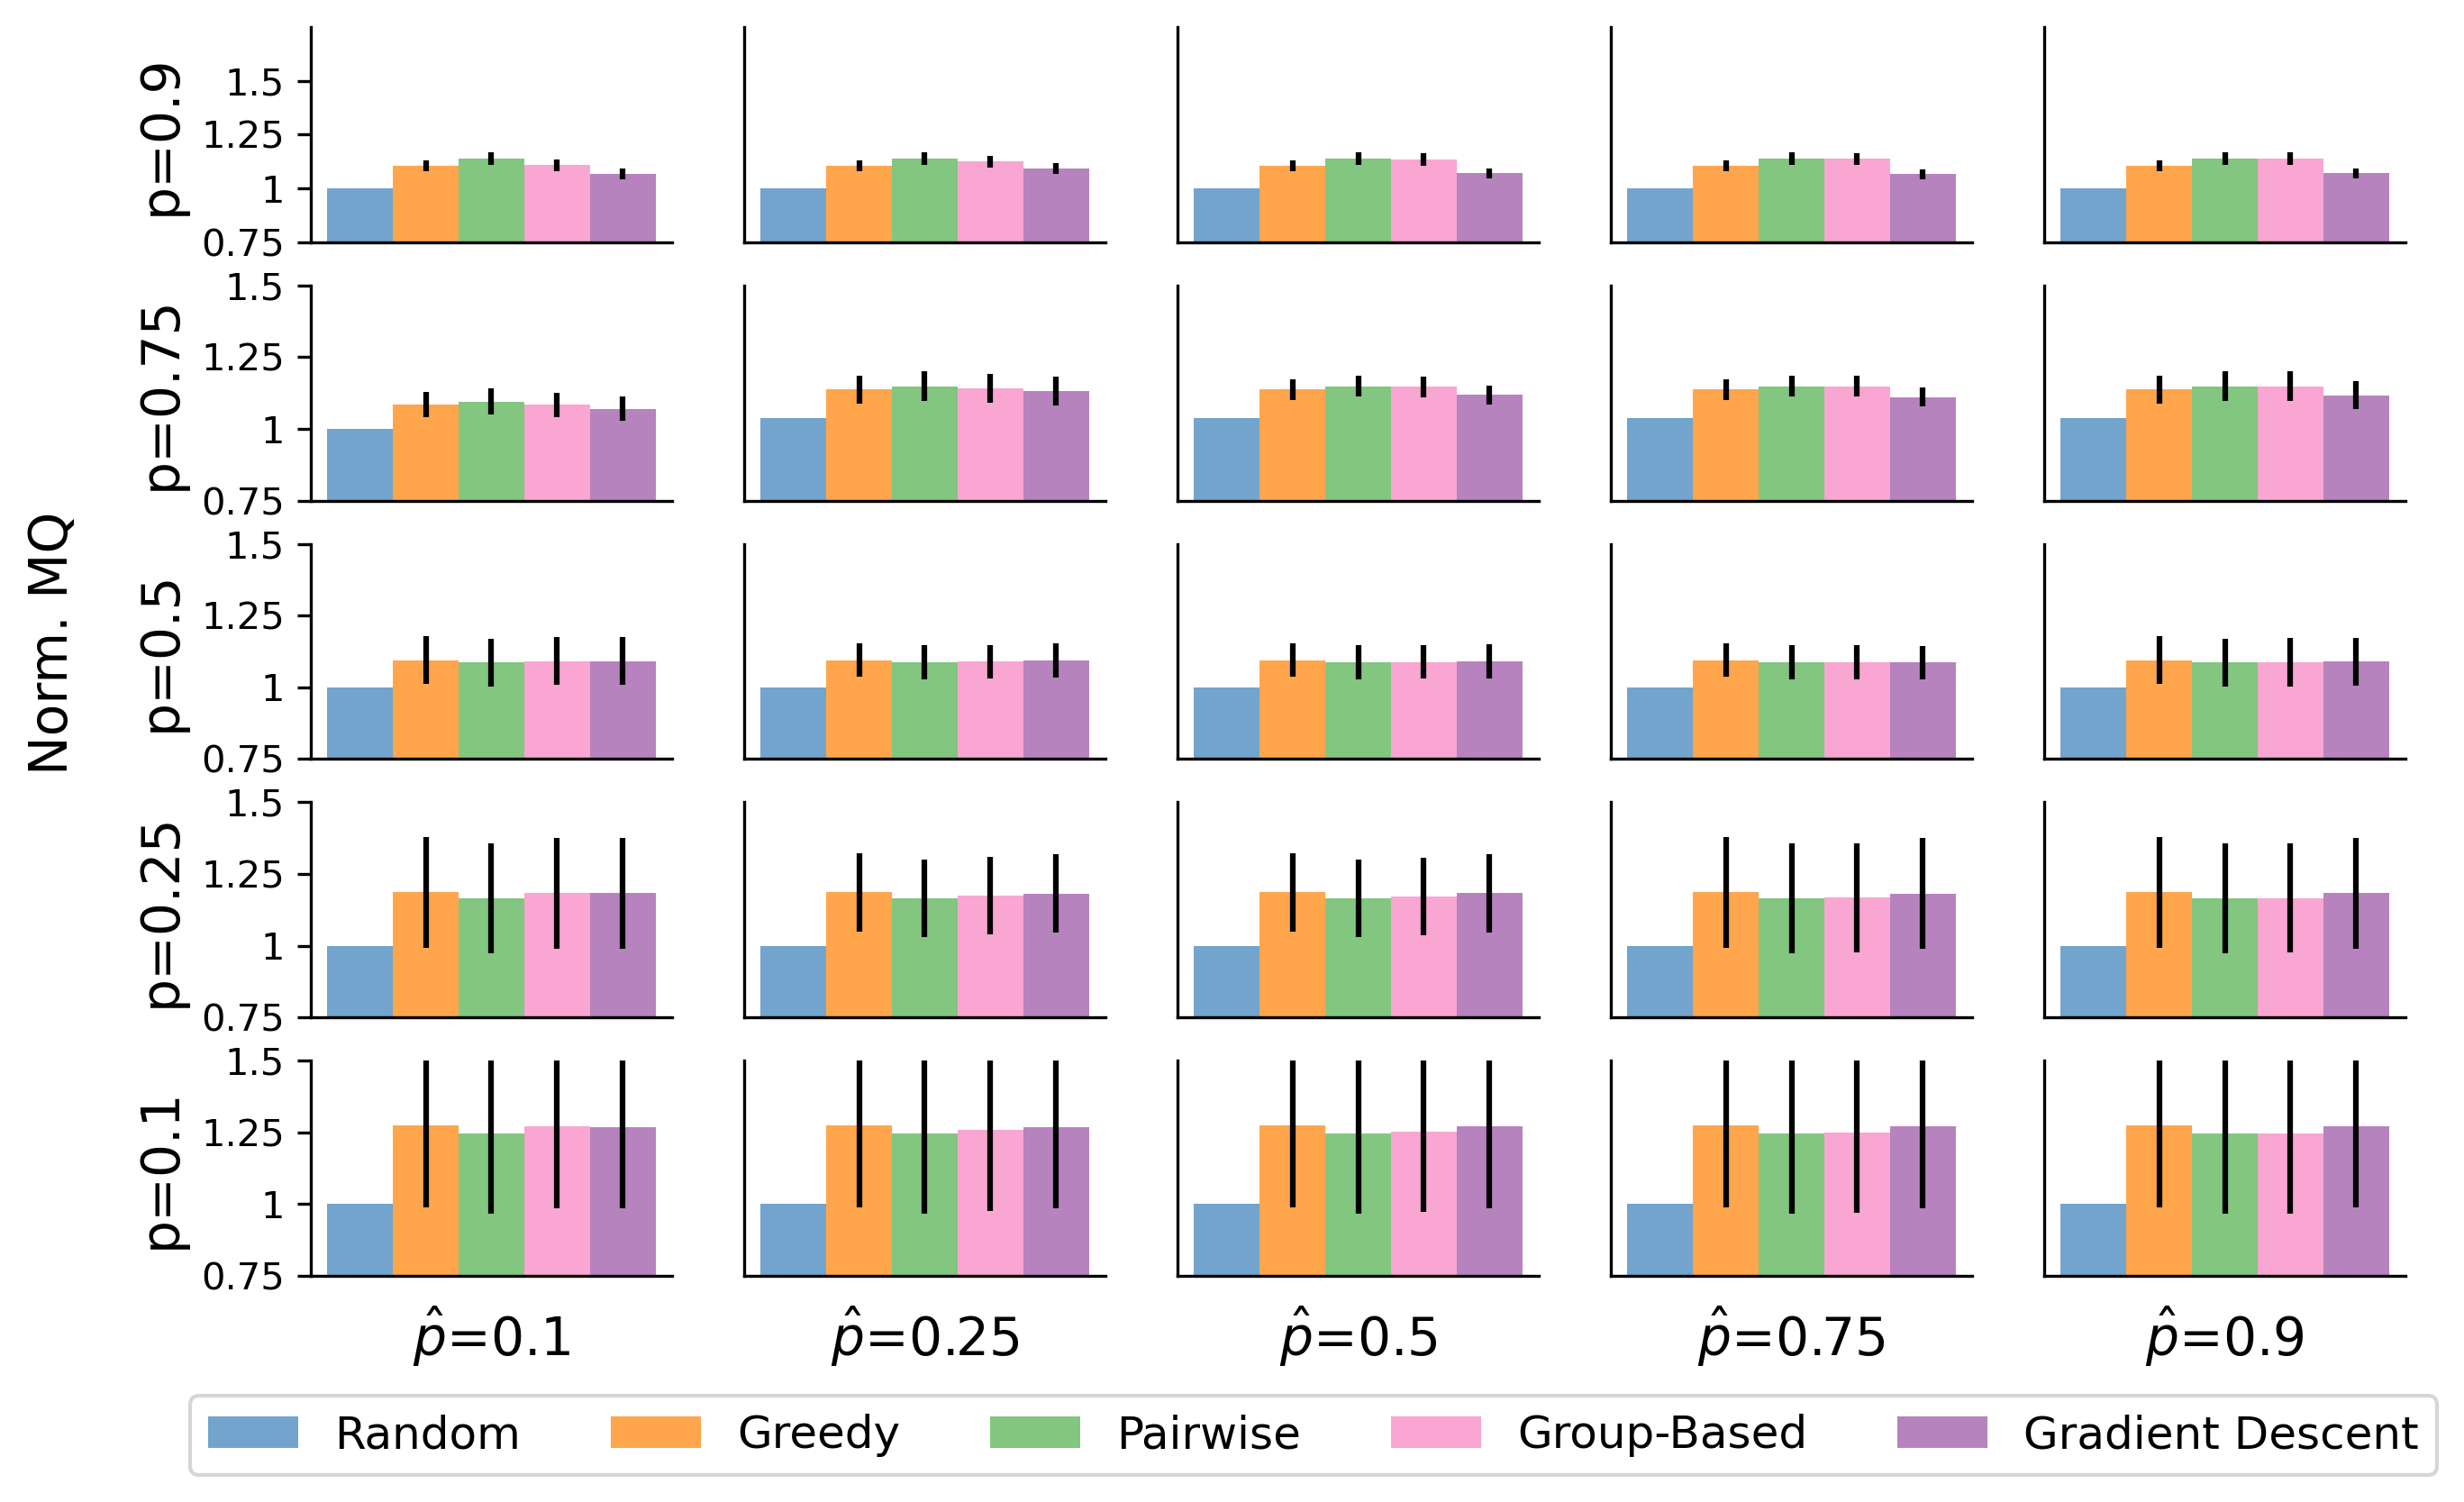

In [106]:
plot_dimensions = (5,5)
x_labels = [["","","","",""],["","","","",""],["","","","",""],["","","","",""],["$\hat{p}$=0.1","$\hat{p}$=0.25","$\hat{p}$=0.5","$\hat{p}$=0.75","$\hat{p}$=0.9"]]
y_labels = [["p=0.9","","","",""],["p=0.75","","","",""],["p=0.5","","","",""],["p=0.25","","","",""],["p=0.1","","","",""]]
sup_y_label = "Norm. MQ"
sup_x_label = ""

y_lim = [[0.75,1.75],[0.75,1.4],[0.75,1.5],[0.75,1.5],[0.75,1.5]]

overall_format = {'figsize':(10, 6),
    'style_size': style_size,
    'x_ticks': [[[[],[]] for i in range(5)] for i in range(5)],
    'y_lim': [[y_lim[j] for i in range(5)] for j in range(5)], 
    'y_ticks': [[[[],[]] if i != 0 else [[0.75,1,1.25,1.5],[0.75,1,1.25,1.5]] for i in range(5)] for i in range(5)],

}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels,sup_y_label=sup_y_label,sup_x_label=sup_x_label,sup_x_label_loc=-0.05)

bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

for i in range(5):
    for j in range(5):
        x_groups = [0,1,2,3,4]
        y_values = y_value_matrix[i][j]
        y_errors = y_confidence_matrix[i][j]
        labels = method_labels
        plot_bar(ax[i][j],x_groups,y_values,y_errors,labels,bar_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.92,0.05)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/misspecification.pdf",dpi=300, bbox_inches='tight')

## Semi-Synthetic

In [31]:
dataset = "semi_synthetic"

y_value_matrix = [0 for i in range(5)]
y_confidence_matrix = [0 for i in range(5)] 

baseline_params = {'num_patients': 1225, 'num_providers': 700, 'max_menu_size': 2000, 'batch_size': 1,'utility_function': 'semi_synthetic_comorbidity', 'fairness_weight': 0}
results = get_results_matching_parameters(dataset,"",baseline_params)
results = [i for i in results if i['parameters']['seed']]
print(len(results))
aggregate_data = aggregate_normalize_data(results,baseline="random")
y_value_matrix = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
y_confidence_matrix = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

15


In [24]:
y_value_matrix[-1]/y_value_matrix[1]

1.131165944899963

In [25]:
y_value_matrix[-1]/y_value_matrix[1]

1.131165944899963

In [15]:
import pandas as pd 
population_csv = pd.read_csv(open("../../data/connecticut_zipcode.csv"))
population_dict = {}
for i in range(len(population_csv)):
    zipcode = str(population_csv.iloc[i,0])
    zipcode = "0"*(5-len(zipcode))+zipcode
    population = int(population_csv.iloc[i,1].replace(",",""))
    population_dict[zipcode] = population

In [16]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
matches_by_zipcode = {}
match_quality_by_zipcode = {}
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)
    match_rates_per = np.array(results[0]['gradient_descent_fast_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))

    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in matches_by_zipcode:
            matches_by_zipcode[zip_val] = []
        matches_by_zipcode[zip_val].append(match_times[i])

    theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])
    theta_data[(theta_data<0.75) & (theta_data>=0.5)] = theta_data[(theta_data<0.75) & (theta_data>=0.5)]+0.25
    theta_data[theta_data>=0.75] = 2*(theta_data[theta_data>=0.75]-0.75)+0.5
    theta_data[theta_data>0] = 10.1/theta_data[theta_data>0]    
    avg_match_quality = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_match_quality[match_times>0] /= match_times[match_times>0]
    for i in range(len(match_times)):
        zip_val = patient_data[i]['location']
        if zip_val not in match_quality_by_zipcode:
            match_quality_by_zipcode[zip_val] = []
        match_quality_by_zipcode[zip_val].append(avg_match_quality[i])

for i in matches_by_zipcode:
    matches_by_zipcode[i] = np.mean(matches_by_zipcode[i])
    match_quality_by_zipcode[i] = np.mean(match_quality_by_zipcode[i])

In [17]:
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Generate random data for each ZIP code
ct_zipcodes["match_rate"] = [matches_by_zipcode[i] if i in matches_by_zipcode else -1 for i in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_quality"] = [match_quality_by_zipcode[i] if i in match_quality_by_zipcode else -1 for i in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes['population'] = [population_dict[i] if i in population_dict else 0 for i in ct_zipcodes["ZCTA5CE10"]]

cmap = mcolors.ListedColormap(["grey"] + plt.cm.coolwarm(np.linspace(0, 1, 256)).tolist())
norm = mcolors.BoundaryNorm(boundaries=[-1, 0, 1], ncolors=cmap.N, extend="both")


In [18]:
population = np.array(list(ct_zipcodes['population']))
match_rate = np.array(list(ct_zipcodes['match_rate']))
population = population[match_rate > -1]
match_rate = match_rate[match_rate>-1]
coefficients = np.polyfit(population, match_rate, 1)  # Fit a 2nd-degree polynomial
poly = np.poly1d(coefficients)  # Create a polynomial function

# Generate points for the fitted polynomial curve
x_fit = np.linspace(min(population), max(population), 1000)  # Create smooth x values
y_fit = poly(x_fit)  # Get corresponding y values for the fitted curve


In [19]:
def get_dist(theta_val):
    if theta_val < 0.5:
        return 0
    elif theta_val <= 0.75:
        return 10.1/(2*(theta_val-0.5) + 0.5)
    else:
        return 10.1/(2*(theta_val-0.75)+0.5)

In [20]:
theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])

In [21]:
np.sum(theta_data*match_rates_per[0])/1225

0.40721862079775795

In [22]:
dataset="semi_synthetic"
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'max_menu_size': 2000, 'fairness_weight': 0.0}
matches_by_comorbidity = {0: [], 1: []} 
distance_by_comorbidity = {0: [], 1: []}
qual_by_comorbidity = {0: [], 1: []}
percent_providers_matched_specialist = []
s = []
for seed in range(43,58):
    baseline_params['seed'] = seed
    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))

    match_rates_per = np.array(results[0]['gradient_descent_fast_matches_per'])
    match_times = np.sum(match_rates_per[0],axis=1)
    patient_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))
    theta_data = json.load(open("../../data/patient_data_{}_1225_700_comorbidity.json".format(seed)))

    comorbidity_by_patient = []
    temp_matches_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        has_comorbidity = 1 in [patient_data[i][c] for c in ['cardio','gastro','neuro','substance','onco']]
        comorbidity_by_patient.append(int(has_comorbidity))
        temp_matches_by_comorbidity[int(has_comorbidity)].append(match_times[i])
    s.append(np.mean(comorbidity_by_patient))
    for i in range(2):
        matches_by_comorbidity[i].append(np.mean(temp_matches_by_comorbidity[i]))

    theta_data = np.array(json.load(open("../../data/{}_1225_700_comorbidity.json".format(seed)))[0])

    get_dist_vectorized = np.vectorize(get_dist)
    distance_data = get_dist_vectorized(theta_data)


    avg_dist_by_user = np.sum(distance_data*match_rates_per[0],axis=1)
    avg_dist_by_user[match_times>0]/= match_times[match_times>0]
    temp_distance_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        if avg_dist_by_user[i]>0:
            temp_distance_by_comorbidity[comorbidity_by_patient[i]].append(avg_dist_by_user[i])
    for i in range(2):
        distance_by_comorbidity[i].append(np.mean(temp_distance_by_comorbidity[i]))

    avg_qual_by_user = np.sum(theta_data*match_rates_per[0],axis=1)
    avg_qual_by_user[match_times>0]/= match_times[match_times>0]
    temp_qual_by_comorbidity = {0: [], 1: []}
    for i in range(len(match_times)):
        if avg_dist_by_user[i]>0:
            temp_qual_by_comorbidity[comorbidity_by_patient[i]].append(avg_qual_by_user[i])
    for i in range(2):
        qual_by_comorbidity[i].append(np.mean(temp_qual_by_comorbidity[i]))

    specialty_grouping = {
        'cardio': ['CARDIOVASCULAR DISEASE (CARDIOLOGY)','ADVANCED HEART FAILURE AND TRANSPLANT CARDIOLOGY','INTERVENTIONAL CARDIOLOGY','CARDIAC ELECTROPHYSIOLOGY','PERIPHERAL VASCULAR DISEASE','CRITICAL CARE (INTENSIVISTS)'], 
        'gastro': ['NEPHROLOGY','ENDOCRINOLOGY'],
        'neuro': ['CRITICAL CARE (INTENSIVISTS)','GERIATRIC MEDICINE','SLEEP MEDICINE'],
        'substance': ['ADDICTION MEDICINE'], 
        'onco': ['CRITICAL CARE (INTENSIVISTS)','HEMATOLOGY','MEDICAL ONCOLOGY'],
    }
    provider_data = json.load(open("../../data/provider_data_{}_1225_700_comorbidity.json".format(seed)))

    providers_with_speciality = [False for i in range(700)]
    for i in range(700):
        for spec in specialty_grouping:
            providers_with_speciality[i]  = providers_with_speciality[i] or any([s in provider_data[i]['sec_spec_all'] for s in specialty_grouping[spec]])
    
    percent_providers_matched_specialist.append(np.sum(theta_data[theta_data>0.75]*match_rates_per[0][theta_data>0.75])/np.sum(providers_with_speciality))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [23]:
np.mean(s)

0.535673469387755

In [24]:
np.mean(percent_providers_matched_specialist)

0.8983817928910075

In [25]:
np.mean(temp_matches_by_comorbidity[0]), np.mean(temp_matches_by_comorbidity[1])

(0.5607241379310345, 0.5642170542635659)

In [26]:
stats.ttest_ind(qual_by_comorbidity[0], qual_by_comorbidity[1])

Ttest_indResult(statistic=-19.34845405041864, pvalue=9.65239474818039e-18)

In [27]:
np.mean(distance_by_comorbidity[1])/np.mean(distance_by_comorbidity[0])

1.0148111762842795

In [28]:
np.mean(qual_by_comorbidity[1])/np.mean(qual_by_comorbidity[0])

1.0760068087674215

(<Figure size 3000x1200 with 1 Axes>, [[<AxesSubplot:ylabel='Match Quality'>]])

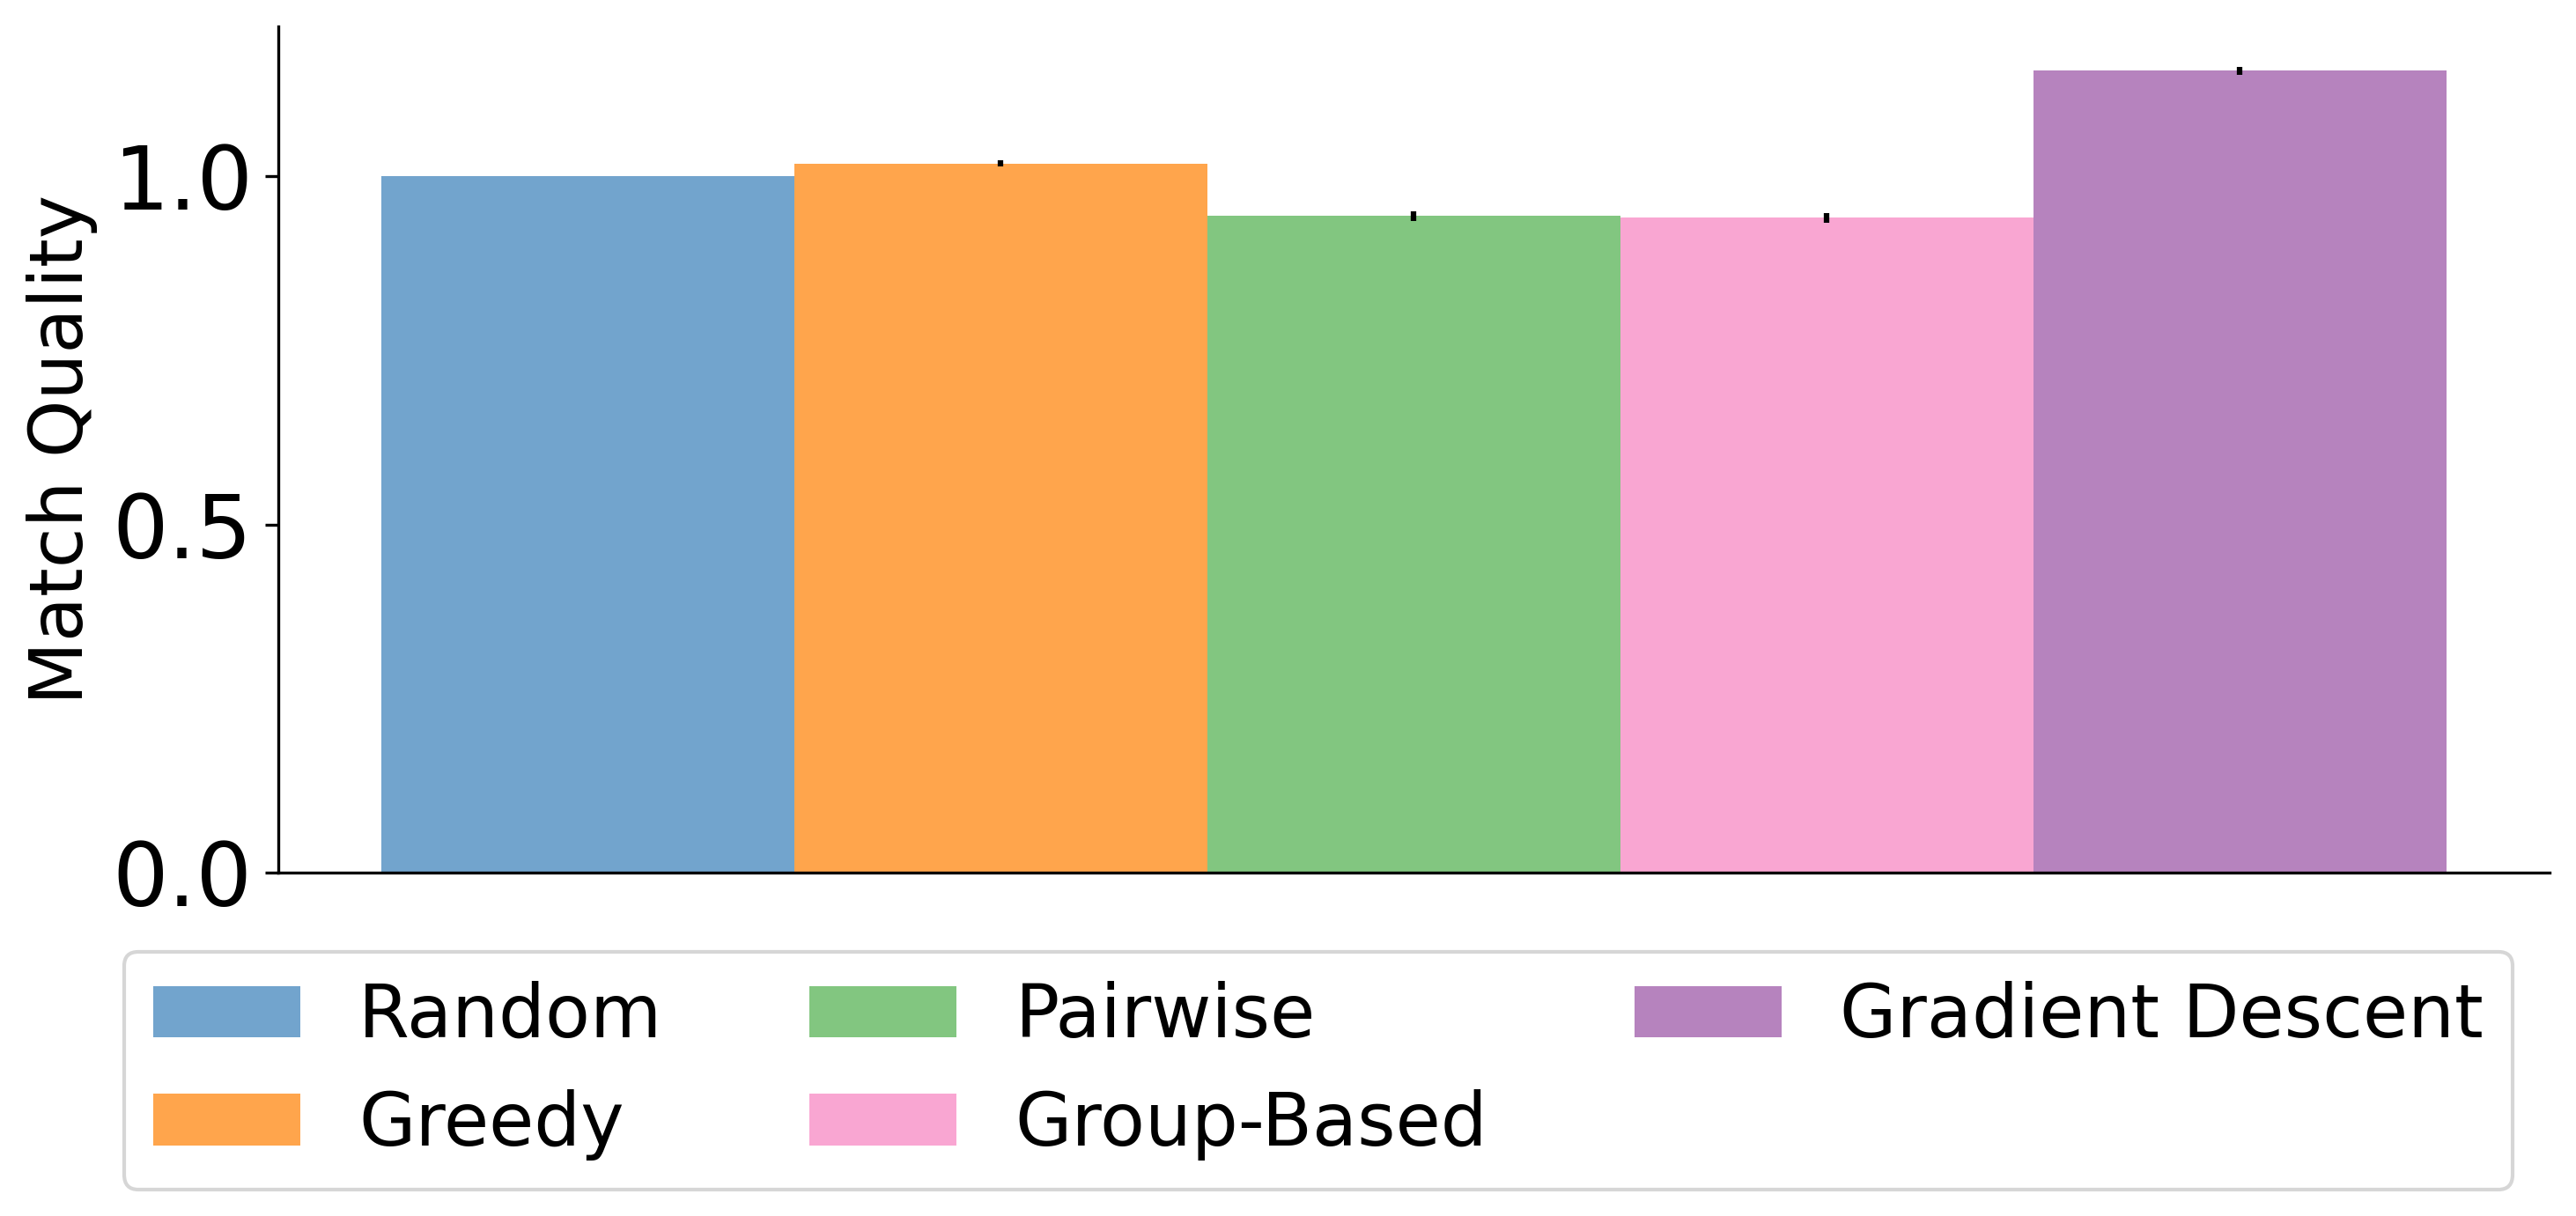

In [42]:
plot_dimensions = (1,1)
x_labels = [["","Match Quality"],["Zipcode Population","Match Rate"]]
y_labels =  [["Match Quality",""],["Match Rate",""]]
x_ticks = [[[[],[]],None],[[[0,20000,40000,60000],[0,"2K","4K","6K"]],None]]
sup_y_label = ""
overall_format = {'figsize':(10,4),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 20,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)


bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2,3,4]
y_values = y_value_matrix
y_errors = y_confidence_matrix
labels = method_labels
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)

plt.tight_layout()

legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(1,-0.05),()],[(),()]], 'fontsize': 20}
create_legend(fig,ax,plot_dimensions,legend_format)



/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("coolwarm").copy()


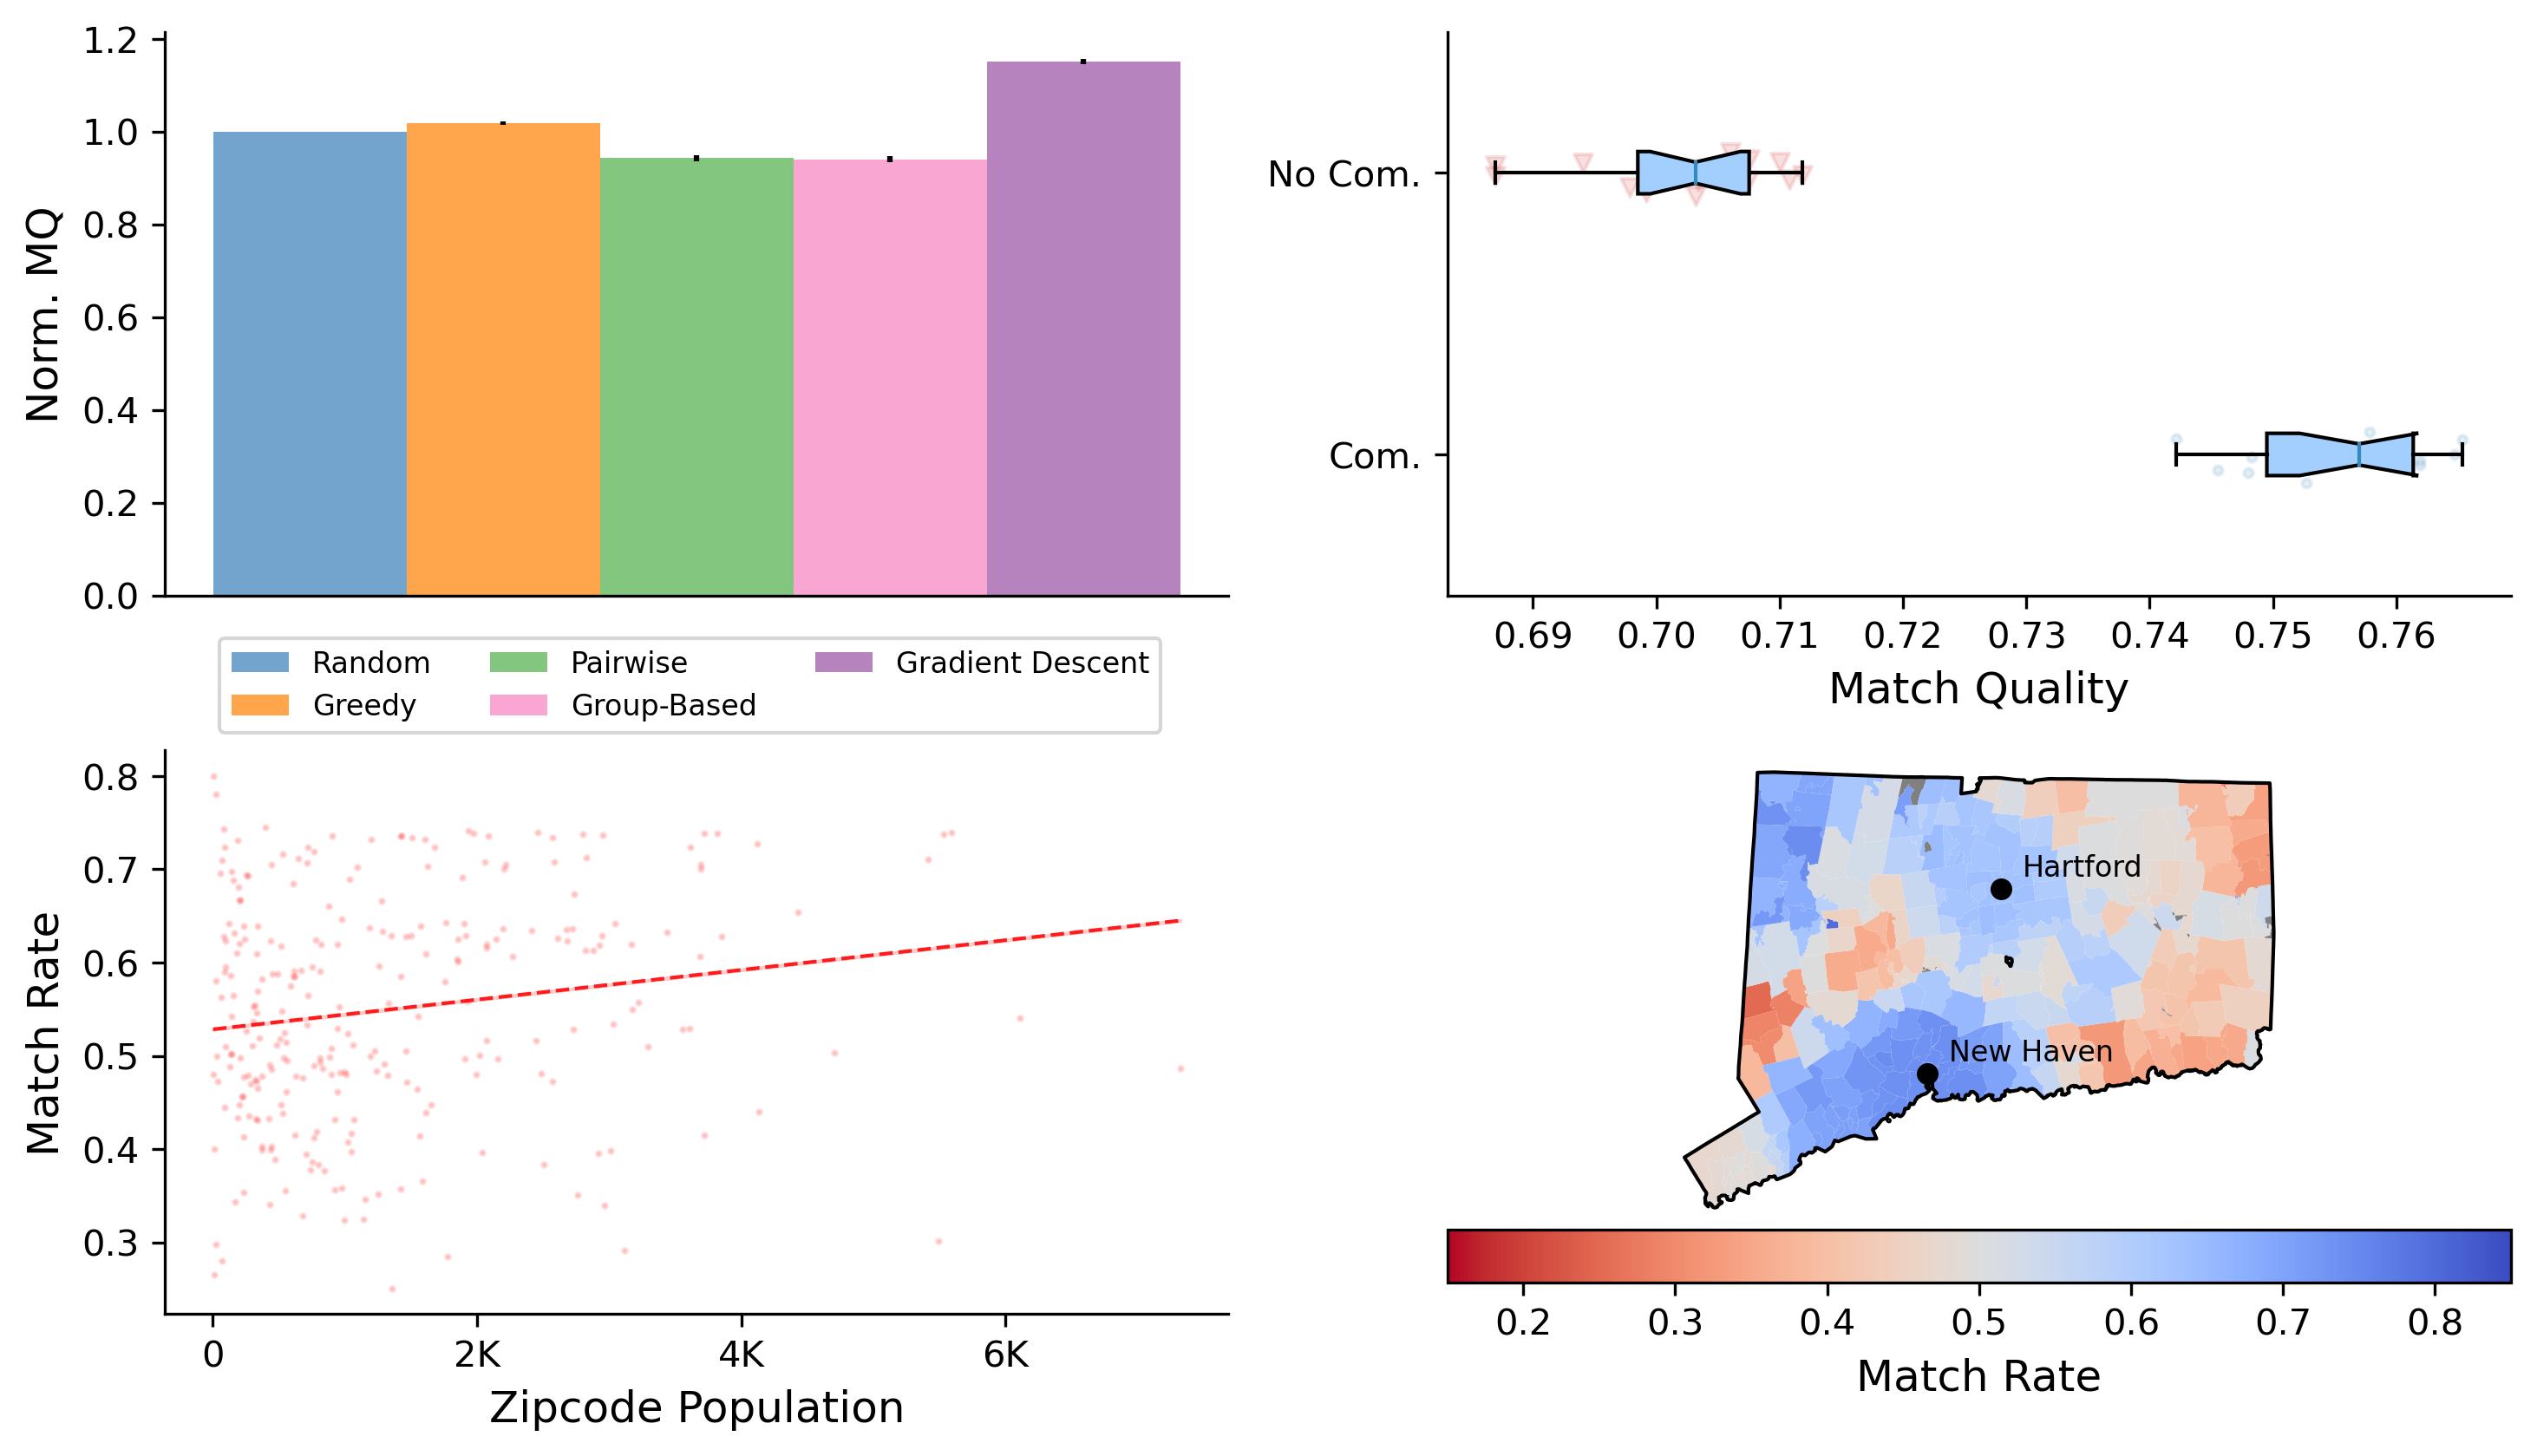

In [32]:
plot_dimensions = (2,2)
x_labels = [["","Match Quality"],["Zipcode Population","Match Rate"]]
y_labels =  [["Norm. MQ",""],["Match Rate",""]]
x_ticks = [[[[],[]],None],[[[0,20000,40000,60000],[0,"2K","4K","6K"]],None]]
sup_y_label = ""
overall_format = {'figsize':(10,6),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 12,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)


bar_format = {'style_size': style_size,
    'color_palette': 'six_color'}

x_groups = [0,1,2,3,4]
y_values = y_value_matrix
y_errors = y_confidence_matrix
labels = method_labels
plot_bar(ax[0][0],x_groups,y_values,y_errors,labels,bar_format)


whisker_format = {'color_palette': '#a2cffe', 'style_size': style_size}
plot_box_whisker(ax[0][1],[qual_by_comorbidity[0],qual_by_comorbidity[1]][::-1],["No Com.","Com."][::-1],whisker_format)

scatter_format = {'color_palette': 'two_color_blue_red_light', 'size': 25}
y_positions = [np.random.normal(i + 1, 0.05, size=len(qual_by_comorbidity[0])) for i in range(2)]
labels = []
plot_scatter(ax[0][1],[qual_by_comorbidity[0],qual_by_comorbidity[1]][::-1],y_positions,labels,scatter_format)


line_format = {'color_palette': '#FF0000DD','no_marker': True, 'linestyle': '--','linewidth': 1}
plot_line(ax[1][0],[x_fit],[y_fit],[[0 for i in range(len(y_fit))]],[""],line_format)
line_format['color_palette'] = '#FF000022'
plot_scatter(ax[1][0],[population],[match_rate],[],line_format)


cmap = plt.cm.coolwarm
cmap.set_under("grey")  # Values below the range (e.g., -1) will be grey
cmap.set_over("grey")   # Optionally, shade values above the range if needed

# Normalize the color range between 0 and 1
norm = mcolors.Normalize(vmin=0.15, vmax=0.85, clip=False)

colorbar = ct_zipcodes.plot(
    column="match_rate",
    cmap=cmap.reversed(),
    norm=norm,
    legend=True,
    legend_kwds={
        'label': "",
        'orientation': "horizontal",
        'shrink': 1,
        'pad': 0,
    },
    ax=ax[1][1]
    
)
cbar = ax[1][1].get_figure().axes[-1]  # Access the colorbar axis
cbar.tick_params(labelsize=10)
cbar.set_xlabel("Match Rate", fontsize=12)  # Increase font size for the label




ct_outline = ct_zipcodes.dissolve()
ct_outline.boundary.plot(ax=ax[1][1], color="black", linewidth=1)

# Enhance the plot
ax[1][1].axis("off")
hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

# Plot dots for Hartford and New Haven
ax[1][1].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
ax[1][1].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

ax[1][1].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=8, zorder=6)
ax[1][1].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=8, zorder=6)


# Show the plot
plt.tight_layout()

legend_format = {'style_size': style_size,'type': 'is_local', 'loc': 'upper right', 'ncol': 3, 'bbox_to_anchor': [[(0.95,-0.05),()],[(),()]], 'fontsize': 8}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/semi_synthetic_main.pdf",dpi=300, bbox_inches='tight')

In [90]:
from matplotlib.transforms import Bbox

x_values = [0.1,5]
x_values.append(x_values[1]+(x_values[1]-x_values[0]))
y_values = [-0.1,2.95,5.8]
fig.savefig("../../results/figures/semi_synthetic_comparison.pdf", bbox_inches=Bbox.from_extents([[x_values[0],y_values[1]],[x_values[1],y_values[2]]]))
fig.savefig("../../results/figures/comorbidity_comparison.pdf", bbox_inches=Bbox.from_extents([[x_values[1],y_values[1]],[x_values[2],y_values[2]]]))
fig.savefig("../../results/figures/scatter_ct.pdf", bbox_inches=Bbox.from_extents([[x_values[0],y_values[0]],[x_values[1],y_values[1]]]))
fig.savefig("../../results/figures/ct_map.pdf", bbox_inches=Bbox.from_extents([[x_values[1],y_values[0]],[x_values[2],y_values[1]]]))


In [82]:
Bbox.from_extents([[1,1],[1,1]])

Bbox([[1.0, 1.0], [1.0, 1.0]])

In [24]:
batch_y_values = []
batch_y_confidences = []
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'max_menu_size': 2000, 'fairness_weight': 0.0}#, 'num_trials': 100, 'order': 'custom'}
dataset = "semi_synthetic"
x_values = [1,2,3,4,5]
for i in range(len(x_values)):
    baseline_params['batch_size'] = x_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = [np.mean(i['optimal_order_utilities'])/1225 for i in results]

    batch_y_values.append(np.mean(aggregate_data))
    batch_y_confidences.append(np.std(aggregate_data)/len(results)**.5)
batch_y_values = [i/batch_y_values[0] for i in batch_y_values]

15
15
15
15
15


In [25]:
y_values = [x_values[i] * np.log(205/x_values[i]) for i in range(len(x_values))]
y_values = [i/y_values[0] for i in y_values]
y_values 

[1.0,
 1.7395657031354508,
 2.380832108352012,
 2.9582628125418027,
 3.488225723094918]

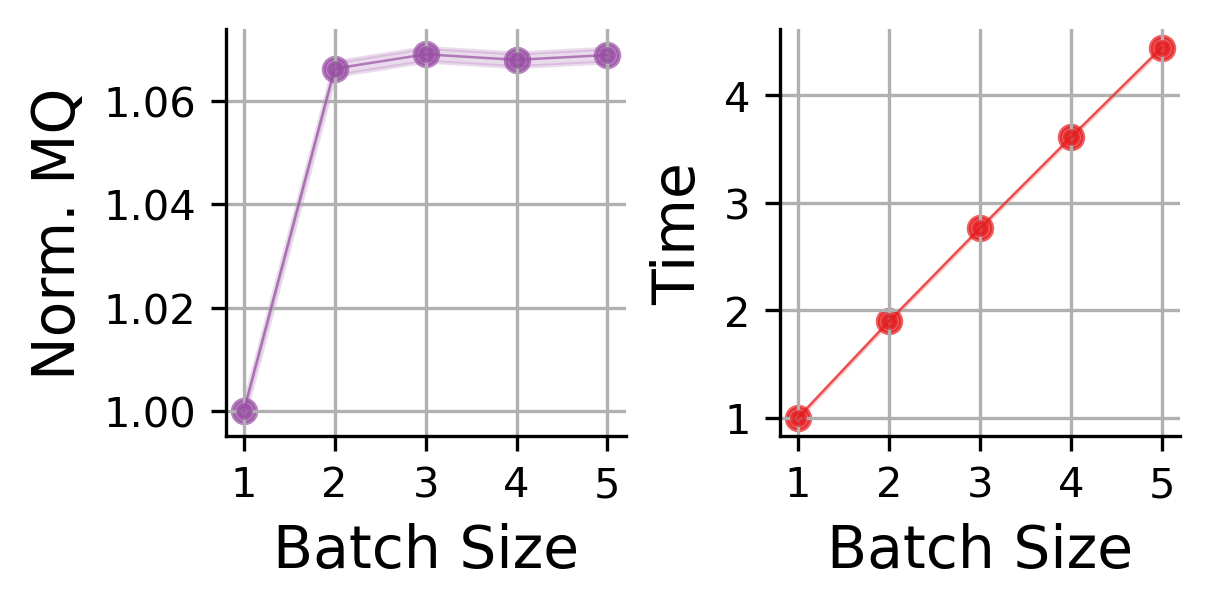

In [27]:
plot_dimensions = (1,2)
x_labels = [["Batch Size","Batch Size"]]
y_labels = [["Norm. MQ","Time"]]
overall_format = {'figsize':(4,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values],[x_values,x_values]]],
    'has_grid': True, 
    'constrained_layout': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-2])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
plot_line(ax[0][0],[x_values],[batch_y_values],batch_y_confidences,["Match Quality"],line_format)
plot_scatter(ax[0][0],[x_values],[batch_y_values],[None],line_format)

color = '#%02x%02x%02x%02x' % tuple(np.round(np.array(color_schemes['six_color'][-1])*256).astype(int).tolist())
line_format = {'color_palette': color, 'size': 125}
y_values = [x_values[i] * np.log(205/x_values[i])/np.log(np.log(205/x_values[i])) for i in range(len(x_values))]
y_values = [i/y_values[0] for i in y_values]
y_confidences = [0 for i in range(len(x_values))]
plot_line(ax[0][1],[x_values],[y_values],[y_confidences],["Time"],line_format)
plot_scatter(ax[0][1],[x_values],[y_values],[None],line_format)

fig.savefig("../../results/figures/batch_size.pdf",dpi=300, bbox_inches='tight')

In [8]:
menu_y_values = [[] for i in range(len(methods))]
menu_confidences = [[] for i in range(len(methods))]
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1}
dataset = "semi_synthetic"
x_values = [5,10,20,40]
for i in range(len(x_values)):
    baseline_params['max_menu_size'] = x_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    print(len(results))
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    for method in range(len(methods)):
        menu_y_values[method].append(aggregate_data['{}_utilities'.format(methods[method])][0])
        menu_confidences[method].append(aggregate_data['{}_utilities'.format(methods[method])][1]/len(results)**.5)

15


/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


15
15
15


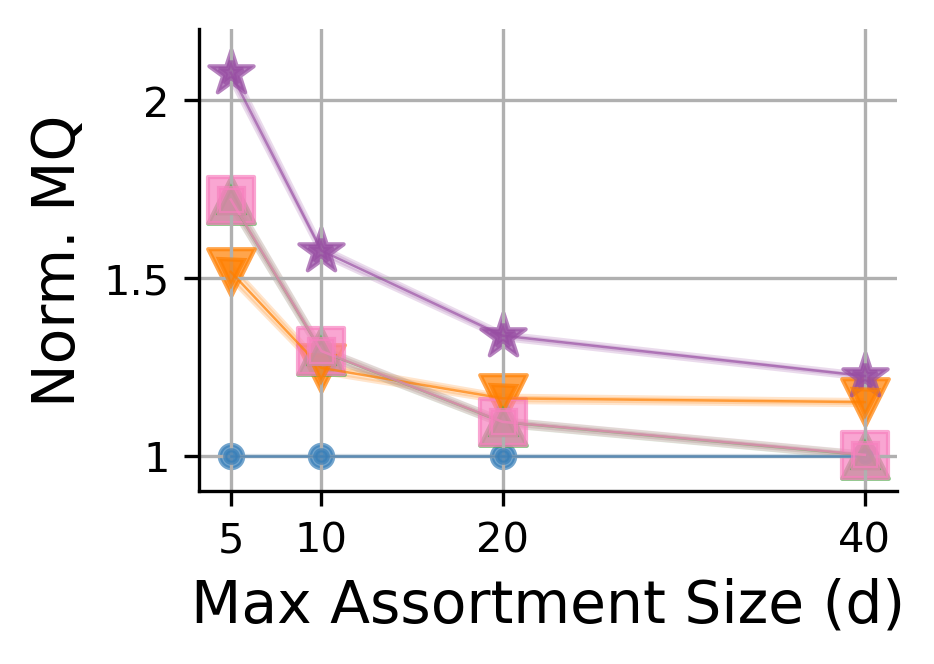

In [9]:
plot_dimensions = (1,1)
x_labels = [["Max Assortment Size (d)"]]
y_labels = [["Norm. MQ"]]
overall_format = {'figsize':(3,2),
    'style_size': style_size,
    'x_ticks': [[[x_values,x_values]]],
    'y_ticks': [[[[1,1.5,2],[1,1.5,2]]]],
    'y_lim': [[[0.9,2.2]]],
    'has_grid': True, 
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

line_format = {'color_palette': 'six_color', 'size': 125}
plot_line(ax[0][0],[x_values for i in range(len(menu_y_values))],menu_y_values,menu_confidences,method_labels,line_format)
plot_scatter(ax[0][0],[x_values for i in range(len(menu_y_values))],menu_y_values,[None for i in range(len(method_labels))],line_format)

# legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'lower left', 'ncol': 1, 'bbox_to_anchor': (1,0.1), 'show_point': True}
# create_legend(fig,ax,plot_dimensions,legend_format)

fig.savefig("../../results/figures/max_menu_size.pdf",dpi=300, bbox_inches='tight')

In [10]:
dataset = "semi_synthetic"

x_value_matrix = [0 for i in range(5)] 
y_value_matrix = [0 for i in range(5)]
y_confidence_matrix = [0 for i in range(5)]

baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'fairness_weight': 0.0, 'max_menu_size': 2000}
results = get_results_matching_parameters(dataset,"",baseline_params)
print(len(results))
aggregate_data = aggregate_normalize_data(results)

x_value_matrix = [aggregate_data['{}_minimums'.format(method)][0] for method in methods]
y_value_matrix = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
y_confidence_matrix = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

15


In [13]:
y_value_matrix = [i/1225 for i in y_value_matrix]

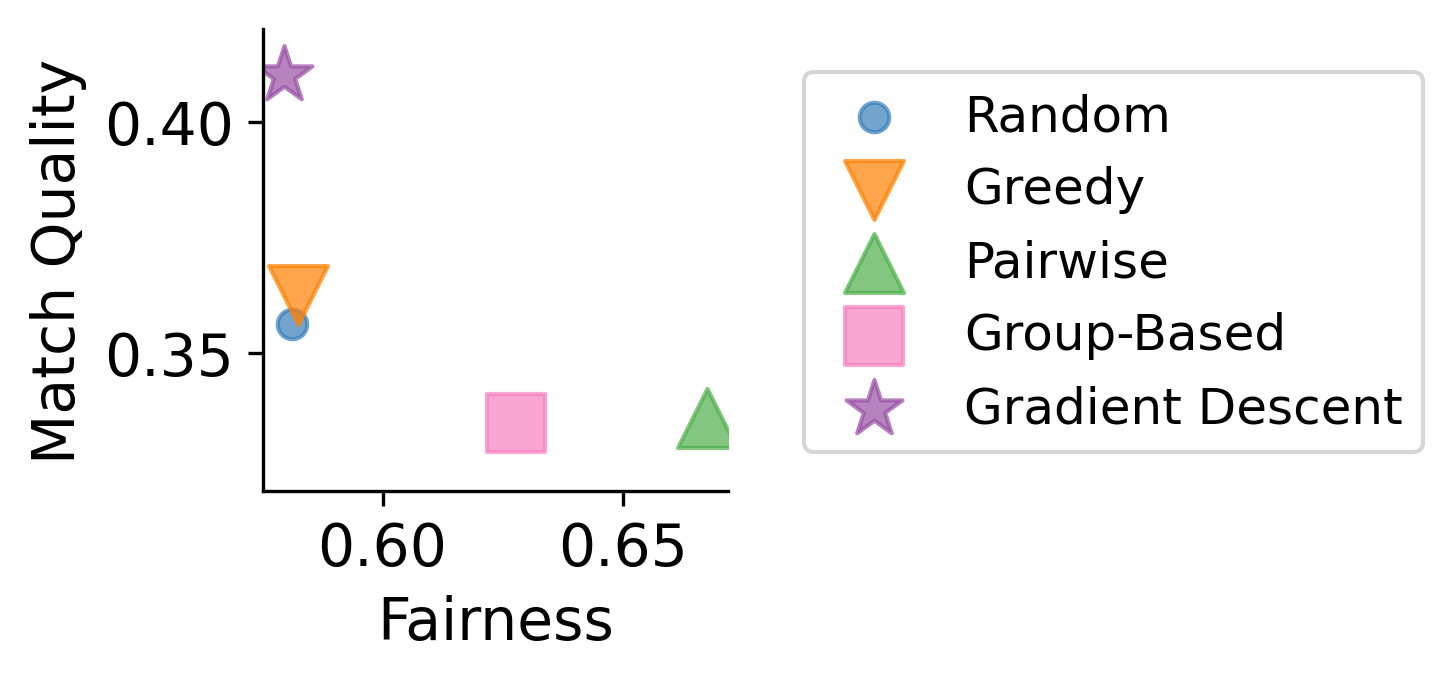

In [14]:
plot_dimensions = (1,1)
x_labels = [["Fairness"]]
y_labels = [["Match Quality"]]

overall_format = {'figsize':(2, 2),
    'style_size': style_size,
    'y_lim': [[[0.32,0.42]]]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

scatter_format = {'color_palette': 'six_color', 'size': 200}

x_values = [[k] for k in x_value_matrix]
y_values = y_value_matrix
y_values = [[k] for k in y_values]
labels = method_labels
plot_scatter(ax[0][0],x_values,y_values,labels,scatter_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 1, 'bbox_to_anchor': (2.1,0.85)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/fairness_comparison.pdf",dpi=300, bbox_inches='tight')

In [33]:
dataset = "semi_synthetic"

x_value_matrix = [0 for i in range(5)] 
y_value_matrix = [0 for i in range(5)]
y_confidence_matrix = [0 for i in range(5)]

baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'fairness_weight': 0.0, 'max_menu_size': 2000}
results = get_results_matching_parameters(dataset,"",baseline_params)
print(len(results))
aggregate_data = aggregate_normalize_data(results)

x_value_matrix = [aggregate_data['{}_variance'.format(method)][0] for method in methods]
y_value_matrix = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
y_confidence_matrix = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

15


In [34]:
y_value_matrix = [i/1225 for i in y_value_matrix]

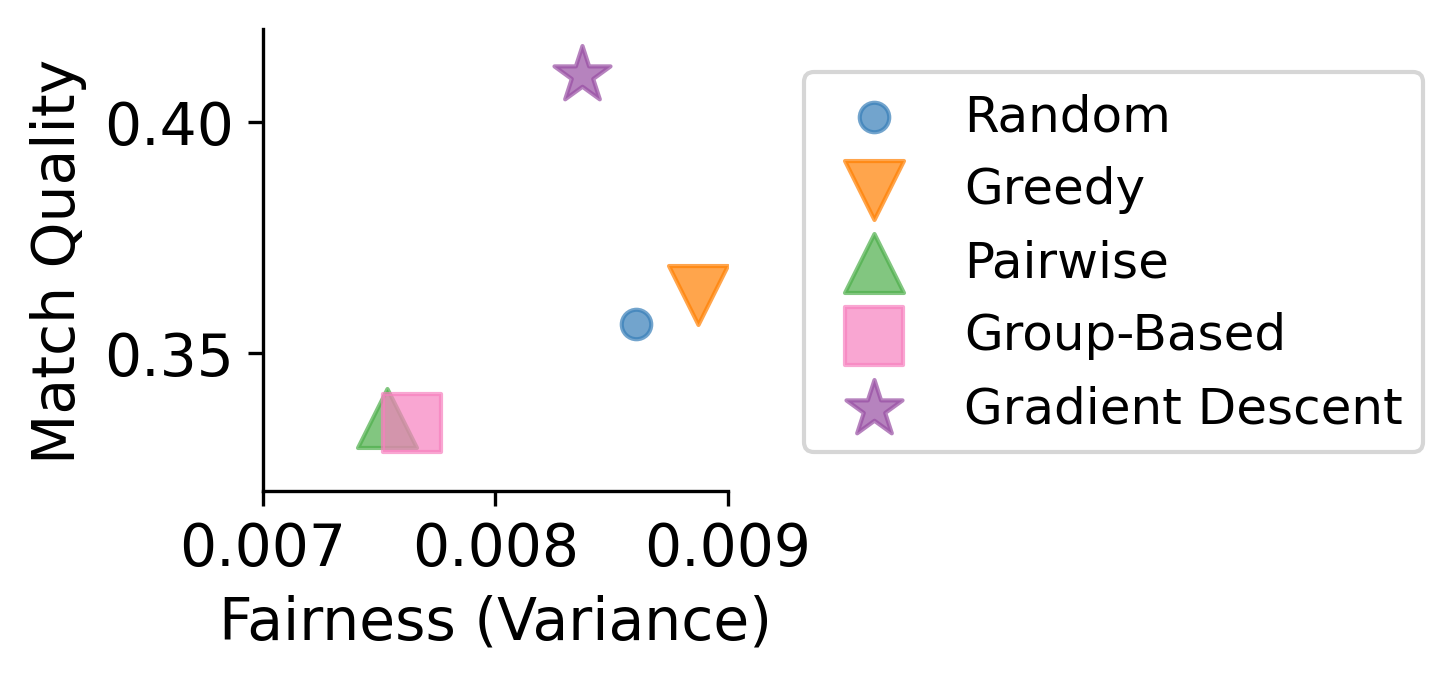

In [35]:
plot_dimensions = (1,1)
x_labels = [["Fairness (Variance)"]]
y_labels = [["Match Quality"]]

overall_format = {'figsize':(2, 2),
    'style_size': style_size,
    'y_lim': [[[0.32,0.42]]],
    'x_lim': [[[0.007,0.009]]]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

scatter_format = {'color_palette': 'six_color', 'size': 200}

x_values = [[k] for k in x_value_matrix]
y_values = y_value_matrix
y_values = [[k] for k in y_values]
labels = method_labels
plot_scatter(ax[0][0],x_values,y_values,labels,scatter_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 1, 'bbox_to_anchor': (2.1,0.85)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/fairness_comparison_variance.pdf",dpi=300, bbox_inches='tight')

In [36]:
dataset = "semi_synthetic"

x_value_matrix = [0 for i in range(5)] 
y_value_matrix = [0 for i in range(5)]
y_confidence_matrix = [0 for i in range(5)]

baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'fairness_weight': 0.0, 'max_menu_size': 2000}
results = get_results_matching_parameters(dataset,"",baseline_params)
print(len(results))
aggregate_data = aggregate_normalize_data(results)

x_value_matrix = [aggregate_data['{}_gaps'.format(method)][0] for method in methods]
y_value_matrix = [aggregate_data['{}_utilities'.format(method)][0] for method in methods]
y_confidence_matrix = [aggregate_data['{}_utilities'.format(method)][1]/((len(results))**.5) for method in methods]

15


In [37]:
y_value_matrix = [i/1225 for i in y_value_matrix]

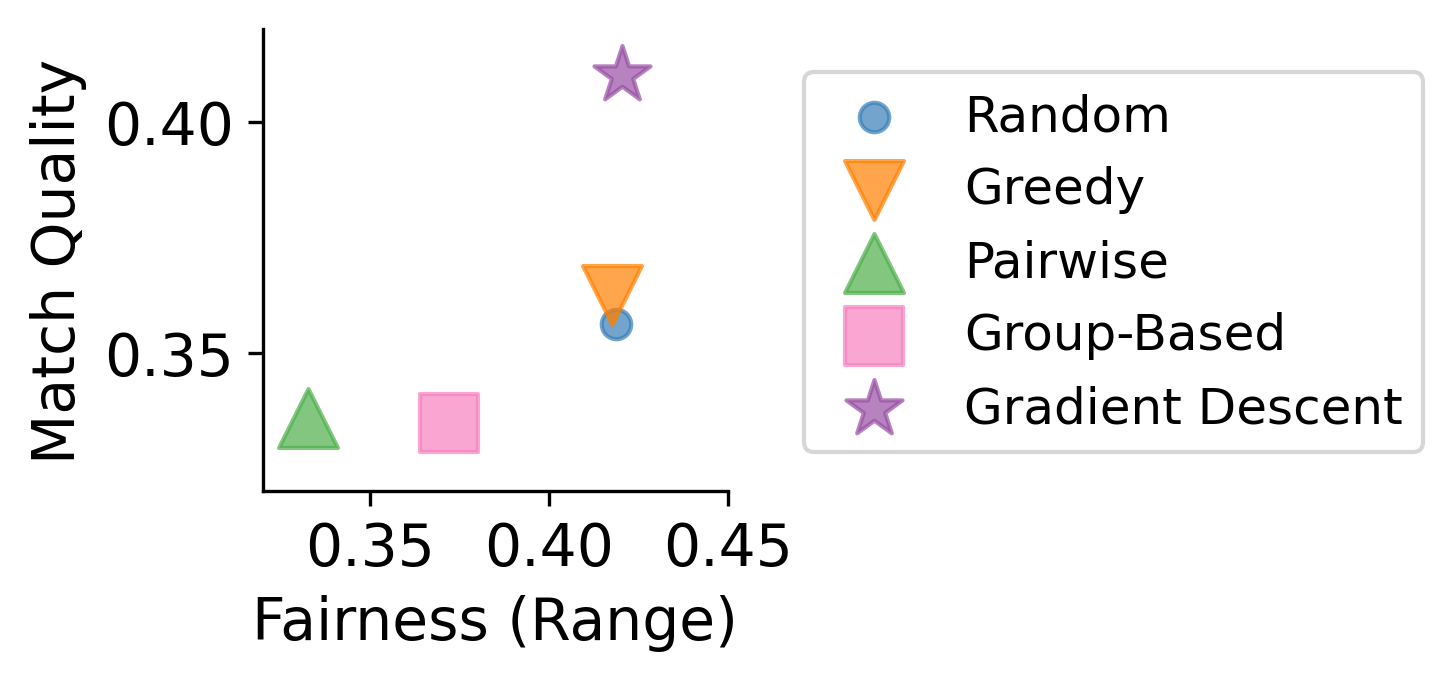

In [38]:
plot_dimensions = (1,1)
x_labels = [["Fairness (Range)"]]
y_labels = [["Match Quality"]]

overall_format = {'figsize':(2, 2),
    'style_size': style_size,
    'y_lim': [[[0.32,0.42]]],
    'x_lim': [[[0.32,0.45]]]
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

scatter_format = {'color_palette': 'six_color', 'size': 200}

x_values = [[k] for k in x_value_matrix]
y_values = y_value_matrix
y_values = [[k] for k in y_values]
labels = method_labels
plot_scatter(ax[0][0],x_values,y_values,labels,scatter_format)

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 1, 'bbox_to_anchor': (2.1,0.85)}
create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/fairness_comparison_range.pdf",dpi=300, bbox_inches='tight')

In [407]:
menu_y_values = [[] for i in range(len(methods))]
menu_confidences = [[] for i in range(len(methods))]
top_choice_probs = [0.1,0.25,0.5,0.75,0.9]
baseline_params = {'utility_function': 'semi_synthetic_comorbidity', 'num_patients': 1225, 'batch_size': 1, 'fairness_weight': 0.0, 'max_menu_size': 2000}
dataset = "semi_synthetic"
fairness_values = [0.1,0.25,0.5,0.75,0.9]

x_values = []
y_values = []
lp_x_values = []
lp_y_values = []
for i in range(len(fairness_values)):
    baseline_params['fairness_weight'] = fairness_values[i]

    results = get_results_matching_parameters(dataset,"",baseline_params)
    aggregate_data = aggregate_normalize_data(results,baseline="random")
    y_values.append(aggregate_data['{}_utilities'.format('lp_fairness')][0])
    x_values.append(aggregate_data['{}_minimums'.format('lp_fairness')][0])

    lp_y_values.append(aggregate_data['{}_utilities'.format('lp')][0])
    lp_x_values.append(aggregate_data['{}_minimums'.format('lp')][0])
    
lp_y_values = [i/1225 for i in lp_y_values]
y_values = [i/1225 for i in y_values]

In [408]:
x_values

[0.6675059715364714,
 0.667384167559377,
 0.667384167559377,
 0.667384167559377,
 0.6675591841218113]

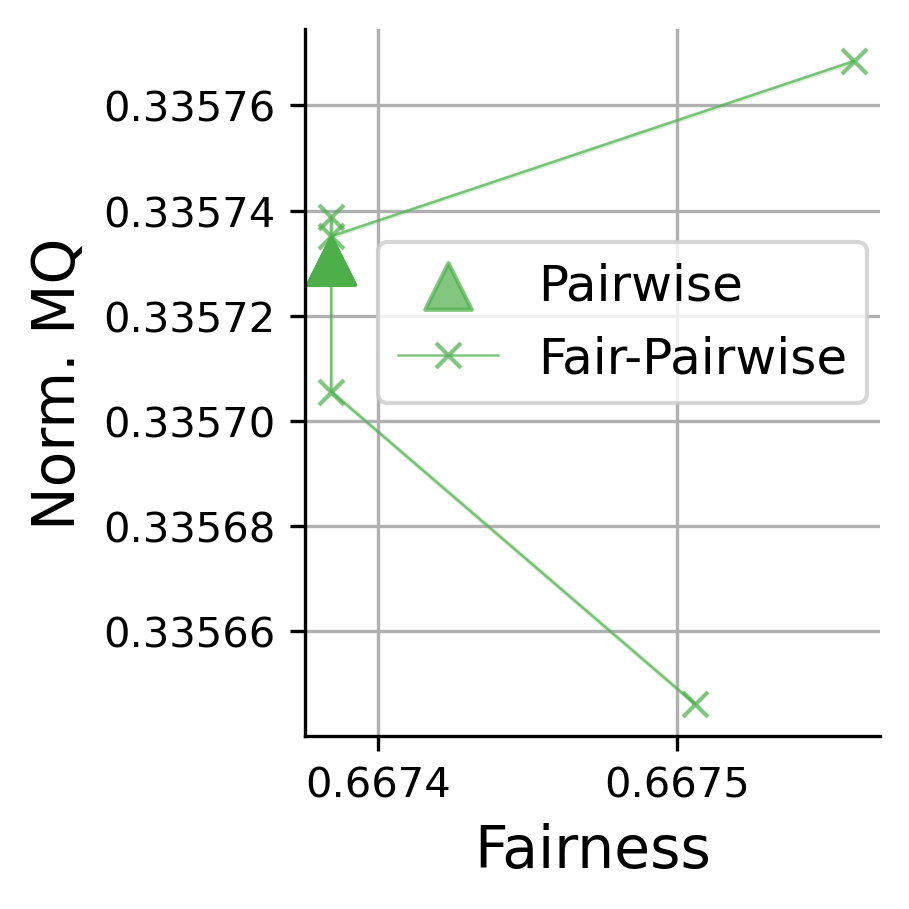

In [409]:
plot_dimensions = (1,1)
x_labels = [["Fairness"]]
y_labels = [["Norm. MQ"]]

overall_format = {'figsize':(3,3),
    'style_size': style_size,
    'has_grid': True, 
    'constrained_layout': True, 
    'x_ticks': [[[[0.6673,0.6674,0.6675],[0.6673,0.6674,0.6675]]]]
}

fig,ax = create_axes(plot_dimensions,overall_format,x_labels=x_labels,y_labels=y_labels)

line_format = {'color_palette': 'six_color', 'size': 125}
plot_scatter(ax[0][0],[[],[],lp_x_values],[[],[],lp_y_values],[None,None,"Pairwise"],line_format)
line_format['color_palette'] = "#4CAF4AB3"
plot_line(ax[0][0],[[],[],[],[],[],x_values],[[],[],[],[],[],y_values],[0 for _ in range(6)],["","","","","","Fair-Pairwise"],line_format)
legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 1, 'bbox_to_anchor': (1,0.75)}
create_legend(fig,ax,plot_dimensions,legend_format)


fig.savefig("../../results/figures/fairness_pareto.pdf",dpi=300, bbox_inches='tight')